#Groundwater hyperparameter tuning

##Libraries

Cargar paquetes

In [1]:
import pickle
import joblib
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import pandas as pd
import seaborn as sns
import geopandas as gpd
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, matthews_corrcoef, roc_auc_score, jaccard_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##Database download

###Load dataset 2022

In [2]:
# Definir la URL para cargar el archivo Excel que contiene datos sobre contaminantes de aguas subterráneas

#subterraneo_completo = pd.read_excel('/content/groundwater_contaminants_2012-2022.xlsx')
url_subterraneo_completo = "https://raw.githubusercontent.com/Ricardo8932/Paper/main/Database/Groundwater/groundwater_contaminants_2012-2022_p.xlsx"
url_subterraneo_sites = "https://raw.githubusercontent.com/Ricardo8932/Paper/main/Database/Groundwater/groundwater_sites.xlsx"

In [3]:
# Cargar el DataFrame 'subterraneo' desde un archivo Excel en la URL especificada

subterraneo_completo = pd.read_excel(url_subterraneo_completo)
subterraneo_sites = pd.read_excel(url_subterraneo_sites)

##Preprocessing

In [4]:
subterraneo = subterraneo_completo.copy()

In [5]:
# Obtener los índices (números de fila) del DataFrame 'subterraneo' y almacenarlos en la variable 'subterraneo_row_idx'
subterraneo_row_idx = subterraneo.index
subterraneo_row_idx

RangeIndex(start=0, stop=12700, step=1)

In [6]:
# Obtener los nombres de las columnas del DataFrame 'subterraneo' y almacenarlos en la variable 'subterraneo_col_idx'
subterraneo_col_idx = subterraneo.columns

# Mostrar los nombres de las columnas del DataFrame 'subterraneo'
subterraneo_col_idx


Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'AÑO', 'Alc_Tot',
       'Cond_elec', 'Dur_Tot', 'SDT', 'Fe_Tot', 'Mn_Tot', 'Fluo', 'CF',
       'N_NO3', 'As_Tot', 'Cd_Tot', 'Cr_Tot', 'Hg_Tot', 'Pb_Tot'],
      dtype='object')

In [7]:
# Mostrar los tipos de datos de cada columna en el DataFrame 'subterraneo'
subterraneo.dtypes


,0
CLAVE SITIO,object
CLAVE MONITOREO,object
NOMBRE DEL SITIO,object
TIPO CUERPO DE AGUA,object
FECHA REALIZACIÓN,datetime64[ns]
AÑO,int64
Alc_Tot,object
Cond_elec,object
Dur_Tot,object
SDT,object


In [8]:
# Mostrar las primeras 5 filas del DataFrame 'subterraneo'
subterraneo.head()

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,Alc_Tot,Cond_elec,Dur_Tot,SDT,Fe_Tot,Mn_Tot,Fluo,CF,N_NO3,As_Tot,Cd_Tot,Cr_Tot,Hg_Tot,Pb_Tot
0,DLAGU19,DLAGU19-021212,POZO PASO BLANCO,SUBTERRÁNEO,2012-12-16,2012,293.48,900,268.9024,576,NaN,0.5651,0.8163,<3,1.4238,<0.0015,NaN,NaN,NaN,NaN
1,DLAGU19,DLAGU19-260513,POZO PASO BLANCO,SUBTERRÁNEO,2013-05-20,2013,371.135,842,308.4032,538.88,0.8667,0.0072,0.8151,<1,1.6621,<0.0015,<0.001301,0.011,0.0001,<0.00154
2,DLAGU19,DLAGU19-270714,POZO PASO BLANCO,SUBTERRÁNEO,2014-07-22,2014,398.8,867,188,582,0.011,<0.00021,0.857,121,1.515,<0.0015,<0.001301,0.0033,<0.0002013,<0.00154
3,DLAGU19,DLAGU19-190415,POZO PASO BLANCO,SUBTERRÁNEO,2015-04-23,2015,406,930,264.01,604,0.0242,<0.00021,0.80978,<1,1.5341,<0.0015,<0.001301,<0.0012,<0.0002013,<0.00154
4,DLAGU19,DLAGU19-140216,POZO PASO BLANCO,SUBTERRÁNEO,2016-02-11,2016,402,881,266.16,612,<0.0041,<0.00021,0.796525,<1,1.535676,<0.0015,<0.001301,<0.0012,<0.0002013,<0.00154


In [9]:
# Contar el número de valores nulos en cada columna del DataFrame 'subterraneo'
subterraneo.isnull().sum()

,0
CLAVE SITIO,0
CLAVE MONITOREO,0
NOMBRE DEL SITIO,0
TIPO CUERPO DE AGUA,0
FECHA REALIZACIÓN,0
AÑO,0
Alc_Tot,626
Cond_elec,203
Dur_Tot,830
SDT,153


In [10]:
# Mostrar un resumen conciso del DataFrame 'subterraneo'
subterraneo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12700 entries, 0 to 12699
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          12700 non-null  object        
 1   CLAVE MONITOREO      12700 non-null  object        
 2   NOMBRE DEL SITIO     12700 non-null  object        
 3   TIPO CUERPO DE AGUA  12700 non-null  object        
 4   FECHA REALIZACIÓN    12700 non-null  datetime64[ns]
 5   AÑO                  12700 non-null  int64         
 6   Alc_Tot              12074 non-null  object        
 7   Cond_elec            12497 non-null  object        
 8   Dur_Tot              11870 non-null  object        
 9   SDT                  12547 non-null  object        
 10  Fe_Tot               12095 non-null  object        
 11  Mn_Tot               12121 non-null  object        
 12  Fluo                 12155 non-null  object        
 13  CF                   12285 non-

In [11]:
# Obtener los nombres de las columnas del DataFrame 'subterraneo'
columns = subterraneo.columns.values

# Reemplazar caracteres específicos en todas las columnas del DataFrame
subterraneo[columns] = subterraneo[columns].replace({'<':''}, regex=True)  # Eliminar el símbolo '<'
subterraneo[columns] = subterraneo[columns].replace({'>':''}, regex=True)  # Eliminar el símbolo '>'
subterraneo[columns] = subterraneo[columns].replace({'≤':''}, regex=True)  # Eliminar el símbolo '≤'
subterraneo[columns] = subterraneo[columns].replace({'≥':''}, regex=True)  # Eliminar el símbolo '≥'

In [12]:
# Mostrar las primeras 5 filas del DataFrame 'subterraneo' para verificar si se han eliminado los signos '<, ≤' y '>, ≥'
subterraneo.head()

,CLAVE SITIO,CLAVE MONITOREO,NOMBRE DEL SITIO,TIPO CUERPO DE AGUA,FECHA REALIZACIÓN,AÑO,Alc_Tot,Cond_elec,Dur_Tot,SDT,Fe_Tot,Mn_Tot,Fluo,CF,N_NO3,As_Tot,Cd_Tot,Cr_Tot,Hg_Tot,Pb_Tot
0,DLAGU19,DLAGU19-021212,POZO PASO BLANCO,SUBTERRÁNEO,2012-12-16,2012,293.48,900,268.9024,576,NaN,0.5651,0.8163,3,1.4238,0.0015,NaN,NaN,NaN,NaN
1,DLAGU19,DLAGU19-260513,POZO PASO BLANCO,SUBTERRÁNEO,2013-05-20,2013,371.135,842,308.4032,538.88,0.8667,0.0072,0.8151,1,1.6621,0.0015,0.001301,0.011,0.0001,0.00154
2,DLAGU19,DLAGU19-270714,POZO PASO BLANCO,SUBTERRÁNEO,2014-07-22,2014,398.8,867,188,582,0.011,0.00021,0.857,121,1.515,0.0015,0.001301,0.0033,0.0002013,0.00154
3,DLAGU19,DLAGU19-190415,POZO PASO BLANCO,SUBTERRÁNEO,2015-04-23,2015,406,930,264.01,604,0.0242,0.00021,0.80978,1,1.5341,0.0015,0.001301,0.0012,0.0002013,0.00154
4,DLAGU19,DLAGU19-140216,POZO PASO BLANCO,SUBTERRÁNEO,2016-02-11,2016,402,881,266.16,612,0.0041,0.00021,0.796525,1,1.535676,0.0015,0.001301,0.0012,0.0002013,0.00154


In [13]:
# Seleccionar las columnas del DataFrame 'subterraneo' que se desean convertir a tipo numérico (índices del 6 al 19)
columns_to_convert = subterraneo.columns[6:20]

# Convertir las columnas seleccionadas a tipo numérico; cualquier valor que no pueda ser convertido se convertirá en NaN
subterraneo[columns_to_convert] = subterraneo[columns_to_convert].apply(pd.to_numeric, errors='coerce')


In [14]:
# Seleccionar las columnas del DataFrame 'subterraneo' desde la columna 6 hasta la 19 (excluyendo la 20) usando iloc
selected_columns = subterraneo.iloc[:, 6:20]

# Mostrar las primeras 10 filas del DataFrame 'selected_columns'
selected_columns.head(10)


,Alc_Tot,Cond_elec,Dur_Tot,SDT,Fe_Tot,Mn_Tot,Fluo,CF,N_NO3,As_Tot,Cd_Tot,Cr_Tot,Hg_Tot,Pb_Tot
0,293.480,900.0,268.9024,576.00,NaN,0.56510,0.816300,3.0,1.423800,0.00150,NaN,NaN,NaN,NaN
1,371.135,842.0,308.4032,538.88,0.86670,0.00720,0.815100,1.0,1.662100,0.00150,0.001301,0.01100,0.000100,0.00154
2,398.800,867.0,188.0000,582.00,0.01100,0.00021,0.857000,121.0,1.515000,0.00150,0.001301,0.00330,0.000201,0.00154
3,406.000,930.0,264.0100,604.00,0.02420,0.00021,0.809780,1.0,1.534100,0.00150,0.001301,0.00120,0.000201,0.00154
4,402.000,881.0,266.1600,612.00,0.00410,0.00021,0.796525,1.0,1.535676,0.00150,0.001301,0.00120,0.000201,0.00154
5,401.120,861.0,268.1046,576.00,0.00410,0.00021,0.702500,10.0,1.741013,0.00150,0.001301,0.00120,0.000160,0.00154
6,368.640,871.0,245.8008,580.00,0.00410,0.00021,0.826700,10.0,1.849185,0.01789,0.001301,0.00395,0.000201,0.00154
7,486.140,999.0,261.5694,604.00,0.00706,0.00021,0.787100,10.0,2.032986,0.01093,0.001301,0.00274,0.000201,0.00154
8,398.040,886.0,230.7144,578.00,0.00810,0.00021,0.845900,10.0,1.955307,0.00150,0.001301,0.00450,0.000201,0.00154
9,403.300,826.0,243.4170,546.40,0.00750,0.00021,0.850500,10.0,1.994880,0.01070,0.001301,0.00500,0.000201,0.00154


In [15]:
# Mostrar información general sobre el DataFrame 'subterraneo'
subterraneo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12700 entries, 0 to 12699
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CLAVE SITIO          12700 non-null  object        
 1   CLAVE MONITOREO      12700 non-null  object        
 2   NOMBRE DEL SITIO     12700 non-null  object        
 3   TIPO CUERPO DE AGUA  12700 non-null  object        
 4   FECHA REALIZACIÓN    12700 non-null  datetime64[ns]
 5   AÑO                  12700 non-null  int64         
 6   Alc_Tot              12074 non-null  float64       
 7   Cond_elec            12497 non-null  float64       
 8   Dur_Tot              11870 non-null  float64       
 9   SDT                  12547 non-null  float64       
 10  Fe_Tot               12095 non-null  float64       
 11  Mn_Tot               12121 non-null  float64       
 12  Fluo                 12155 non-null  float64       
 13  CF                   12285 non-

In [16]:
# Cambiar el tipo de datos de las columnas 'AÑO', 'LATITUD' y 'LONGITUD' a 'object' en el DataFrame 'subterraneo'
subterraneo = subterraneo.astype({'AÑO':'object','FECHA REALIZACIÓN':'object'})

In [17]:
# Obtener estadísticas descriptivas de las columnas numéricas del DataFrame 'subterraneo'
subterraneo.describe()

,Alc_Tot,Cond_elec,Dur_Tot,SDT,Fe_Tot,Mn_Tot,Fluo,CF,N_NO3,As_Tot,Cd_Tot,Cr_Tot,Hg_Tot,Pb_Tot
count,12074.000000,12497.00000,11870.000000,12547.000000,12095.000000,12121.000000,12155.000000,12285.000000,12348.000000,12377.00000,10626.000000,10561.000000,11480.000000,10521.000000
mean,234.025192,1121.96413,352.681207,813.755734,0.191113,0.107418,1.061010,468.754416,4.372299,0.01619,0.001432,0.007256,0.000273,0.002640
std,119.102688,1342.38636,412.411494,1258.294228,1.809529,3.765399,1.901943,7481.129080,8.772988,0.04176,0.006955,0.165337,0.000753,0.011663
min,25.000000,15.00000,2.000000,0.000000,0.004100,0.000200,0.036400,0.000000,0.020000,0.00080,0.000020,0.000500,0.000030,0.000200
25%,160.060000,466.00000,121.173000,322.000000,0.007800,0.000210,0.278438,3.000000,0.650523,0.00150,0.001301,0.001200,0.000201,0.001540
50%,213.620000,774.67000,245.206000,520.000000,0.032970,0.000210,0.530137,10.000000,2.011050,0.00150,0.001301,0.001200,0.000201,0.001540
75%,293.475000,1301.00000,430.006000,890.740000,0.110925,0.007900,1.129300,30.000000,4.921316,0.01390,0.001301,0.001900,0.000201,0.001540
max,3277.600000,62333.00000,9016.000000,82170.000000,178.615000,410.071000,45.213200,640000.000000,241.703000,0.70170,0.612000,15.000000,0.057340,0.526300


In [18]:
# Eliminar filas del DataFrame 'subterraneo' que contienen valores nulos
subterraneo_preprocesado = subterraneo.dropna()

In [19]:
# Mostrar información resumida sobre el DataFrame 'subterraneo'
subterraneo_preprocesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9319 entries, 1 to 12596
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   float

In [20]:
# Guardar el DataFrame 'subterraneo' en un archivo Excel llamado 'subterraneo_preprocesado.xlsx'
subterraneo_preprocesado.to_excel("subterraneo_preprocesado.xlsx")

##Water quality

###Funciones para las columnas 'calidad_' y 'cumple_'


In [21]:
# Crea un nuevo DataFrame 'data_subterraneo' asignando valores NaN a las columnas para la calidad del agua y el cumplimiento de cada contaminante
data_subterraneo = subterraneo_preprocesado.assign(calidad_Alc_Tot=np.nan,calidad_Cond_elec=np.nan,calidad_Dur_Tot=np.nan,calidad_SDT=np.nan,calidad_Fe_Tot=np.nan,calidad_Mn_Tot=np.nan,calidad_Fluo=np.nan,
                                      calidad_CF=np.nan, calidad_N_NO3=np.nan,calidad_As_Tot=np.nan,calidad_Cd_Tot=np.nan,calidad_Cr_Tot=np.nan,calidad_Hg_Tot=np.nan,calidad_Pb_Tot=np.nan,
                                      cumple_Alc_Tot=np.nan,cumple_Cond_elec=np.nan,cumple_Dur_Tot=np.nan,cumple_SDT=np.nan,cumple_Fe_Tot=np.nan,cumple_Mn_Tot=np.nan,cumple_Fluo=np.nan,
                                      cumple_CF=np.nan, cumple_N_NO3=np.nan,cumple_As_Tot=np.nan,cumple_Cd_Tot=np.nan,cumple_Cr_Tot=np.nan,cumple_Hg_Tot=np.nan,cumple_Pb_Tot=np.nan)

In [22]:
data_subterraneo.columns

Index(['CLAVE SITIO', 'CLAVE MONITOREO', 'NOMBRE DEL SITIO',
       'TIPO CUERPO DE AGUA', 'FECHA REALIZACIÓN', 'AÑO', 'Alc_Tot',
       'Cond_elec', 'Dur_Tot', 'SDT', 'Fe_Tot', 'Mn_Tot', 'Fluo', 'CF',
       'N_NO3', 'As_Tot', 'Cd_Tot', 'Cr_Tot', 'Hg_Tot', 'Pb_Tot',
       'calidad_Alc_Tot', 'calidad_Cond_elec', 'calidad_Dur_Tot',
       'calidad_SDT', 'calidad_Fe_Tot', 'calidad_Mn_Tot', 'calidad_Fluo',
       'calidad_CF', 'calidad_N_NO3', 'calidad_As_Tot', 'calidad_Cd_Tot',
       'calidad_Cr_Tot', 'calidad_Hg_Tot', 'calidad_Pb_Tot', 'cumple_Alc_Tot',
       'cumple_Cond_elec', 'cumple_Dur_Tot', 'cumple_SDT', 'cumple_Fe_Tot',
       'cumple_Mn_Tot', 'cumple_Fluo', 'cumple_CF', 'cumple_N_NO3',
       'cumple_As_Tot', 'cumple_Cd_Tot', 'cumple_Cr_Tot', 'cumple_Hg_Tot',
       'cumple_Pb_Tot'],
      dtype='object')

In [23]:
# Mostrar información general sobre las nuevas columnas agregadas al DataFrame data_subterraneo
data_subterraneo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9319 entries, 1 to 12596
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   float

Función para la columna calidad_

In [24]:
#---------------------------calidad_Alc_Tot-------------------------------------------------------------------------
col = 'Alc_Tot'
conditions  = [ (data_subterraneo[col] >= 20) & (data_subterraneo[col] < 75), (data_subterraneo[col] >= 75) & (data_subterraneo[col] <= 150), (data_subterraneo[col] > 150) & (data_subterraneo[col] <= 400),
               data_subterraneo[col] < 20, data_subterraneo[col] > 400 ]
choices     = ['Baja', 'Media', 'Alta', 'Indeseable', 'Indeseable como FAAP' ]
data_subterraneo['calidad_Alc_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Cond_elec-------------------------------------------------------------------
col = 'Cond_elec'
conditions  = [ data_subterraneo[col] <= 250, (data_subterraneo[col] > 250) & (data_subterraneo[col] <= 750), (data_subterraneo[col] > 750) & (data_subterraneo[col] <= 2000),
               (data_subterraneo[col] > 2000) & (data_subterraneo[col] <= 3000), data_subterraneo[col] > 3000 ]
choices     = ['Excelente para riego', 'Buena para riego', 'Permisible para riego', 'Dudosa para riego', 'Indeseable para riego' ]
data_subterraneo['calidad_Cond_elec'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Dur_Tot--------------------------------------------------------------------------------
col = 'Dur_Tot'
conditions  = [ data_subterraneo[col] <= 60, (data_subterraneo[col] > 60) & (data_subterraneo[col] <= 120), (data_subterraneo[col] > 120) & (data_subterraneo[col] <= 500), data_subterraneo[col] > 500 ]
choices     = ['Potable - Suave', 'Potable - Moderadamente suave', 'Potable - Dura', 'Muy dura e indeseable usos industrial y domestico' ]
data_subterraneo['calidad_Dur_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_SDT------------------------------------------------------
col = 'SDT'
conditions  = [ data_subterraneo[col] <= 1000, (data_subterraneo[col] > 1000) & (data_subterraneo[col] <= 2000), (data_subterraneo[col] > 2000) & (data_subterraneo[col] <= 10000), data_subterraneo[col] > 10000 ]
choices     = [ 'Potable - Dulce', 'Ligeramente Salobres', 'Salobres', 'Salinas' ]
data_subterraneo['calidad_SDT'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Fe_Tot-------------------------------------------------------------------------------
col = 'Fe_Tot'
conditions  = [ data_subterraneo[col] <= 0.3, data_subterraneo[col] > 0.3 ]
choices     = ['Potable - Excelente', 'Sin efectos en la salud - Puede dar color al agua' ]
data_subterraneo['calidad_Fe_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Mn_Tot-----------------------------------------------------------------------------
col = 'Mn_Tot'
conditions  = [ data_subterraneo[col] <= 0.15, (data_subterraneo[col] > 0.15) & (data_subterraneo[col] <= 0.4), data_subterraneo[col] > 0.4 ]
choices     = ['Potable - Excelente', 'Sin efectos en la salud - puede dar color al agua', 'Puede afectar la salud' ]
data_subterraneo['calidad_Mn_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Fluo---------------------------------------------------------------------
col = 'Fluo'
conditions  = [(data_subterraneo[col] >= .7) & (data_subterraneo[col] < 1.5), (data_subterraneo[col] >= .4) & (data_subterraneo[col] < .7),
               (data_subterraneo[col] >= 0) & (data_subterraneo[col] < .4), data_subterraneo[col] >= 1.5 ]
choices     = [ 'Potable - Optima', 'Media', 'Baja', 'Alta' ]
data_subterraneo['calidad_Fluo'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_CF-----------------------------------------------------
col = 'CF'
conditions  = [ data_subterraneo[col] < 1.1, (data_subterraneo[col] >= 1.1) & (data_subterraneo[col] <= 200), (data_subterraneo[col] > 200) & (data_subterraneo[col] <= 1000),
               (data_subterraneo[col] > 1000) & (data_subterraneo[col] <= 10000), data_subterraneo[col] > 10000 ]
choices     = [ 'Excelente', 'Buena Calidad', 'Aceptable', 'Contaminada', 'Fuertemente Contaminada' ]
data_subterraneo['calidad_CF'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_N_NO3------------------------------------------------------------------
col = 'N_NO3'
conditions  = [ data_subterraneo[col] <= 5, (data_subterraneo[col] > 5) & (data_subterraneo[col] <= 11), data_subterraneo[col] > 11 ]
choices     = ['Potable - Excelente', 'Potable - Buena calidad', 'No apta como FAAP' ]
data_subterraneo['calidad_N_NO3'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_As_Tot--------------------------------------------------------------------------------
col = 'As_Tot'
conditions  = [ data_subterraneo[col] <= 0.01, (data_subterraneo[col] > 0.01) & (data_subterraneo[col] <= 0.025), data_subterraneo[col] > 0.025 ]
choices     = ['Potable - Excelente', 'Apta como FAAP', 'No apta como FAAP' ]
data_subterraneo['calidad_As_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Cd_Tot--------------------------------------------------------------------------------
col = 'Cd_Tot'
conditions  = [ data_subterraneo[col] <= .003, (data_subterraneo[col] > .003) & (data_subterraneo[col] <= .005), data_subterraneo[col] > .005 ]
choices     = ['Potable - Excelente', 'Apta como FAAP', 'No apta como FAAP' ]
data_subterraneo['calidad_Cd_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Cr_Tot---------------------------------------------------------------------------------
col = 'Cr_Tot'
conditions  = [ data_subterraneo[col] <= 0.05, data_subterraneo[col] > 0.05 ]
choices     = ['Potable - Excelente', 'No apta como FAAP' ]
data_subterraneo['calidad_Cr_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Hg_Tot-----------------------------------------------------------------------------
col = 'Hg_Tot'
conditions  = [ data_subterraneo[col] <= 0.006, data_subterraneo[col] > 0.006 ]
choices     = ['Potable - Excelente', 'No apta como FAAP']
data_subterraneo['calidad_Hg_Tot'] = np.select(conditions, choices, default=np.nan)

#---------------------------calidad_Pb_Tot---------------------------------------------------------------------------------
col = 'Pb_Tot'
conditions  = [ data_subterraneo[col] <= 0.01, data_subterraneo[col] > 0.01 ]
choices     = ['Potable - Excelente', 'No apta como FAAP' ]
data_subterraneo['calidad_Pb_Tot'] = np.select(conditions, choices, default=np.nan)

In [25]:
data_subterraneo.iloc[:5, 20:34] #Columnas tipo de calidad_

,calidad_Alc_Tot,calidad_Cond_elec,calidad_Dur_Tot,calidad_SDT,calidad_Fe_Tot,calidad_Mn_Tot,calidad_Fluo,calidad_CF,calidad_N_NO3,calidad_As_Tot,calidad_Cd_Tot,calidad_Cr_Tot,calidad_Hg_Tot,calidad_Pb_Tot
1,Alta,Permisible para riego,Potable - Dura,Potable - Dulce,Sin efectos en la salud - Puede dar color al agua,Potable - Excelente,Potable - Optima,Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente
2,Alta,Permisible para riego,Potable - Dura,Potable - Dulce,Potable - Excelente,Potable - Excelente,Potable - Optima,Buena Calidad,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente
3,Indeseable como FAAP,Permisible para riego,Potable - Dura,Potable - Dulce,Potable - Excelente,Potable - Excelente,Potable - Optima,Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente
4,Indeseable como FAAP,Permisible para riego,Potable - Dura,Potable - Dulce,Potable - Excelente,Potable - Excelente,Potable - Optima,Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente
5,Indeseable como FAAP,Permisible para riego,Potable - Dura,Potable - Dulce,Potable - Excelente,Potable - Excelente,Potable - Optima,Buena Calidad,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente


In [26]:
data_subterraneo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9319 entries, 1 to 12596
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   float

Función para la columna cumple_

In [27]:
#---------------------------cumple_Alc_Tot-------------------------------------------------------------------------
col = 'calidad_Alc_Tot'
conditions  = [ data_subterraneo[col] == 'Baja', data_subterraneo[col] == 'Media', data_subterraneo[col] == 'Alta', data_subterraneo[col] == 'Indeseable', data_subterraneo[col] == 'Indeseable como FAAP']
choices     = [1, 1, 1, 0, 0]
data_subterraneo['cumple_Alc_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Alc_Tot'] = data_subterraneo['cumple_Alc_Tot'].astype('int32')

#---------------------------cumple_Cond_elec-------------------------------------------------------------------
col = 'calidad_Cond_elec'
conditions  = [ data_subterraneo[col] == 'Excelente para riego', data_subterraneo[col] == 'Buena para riego', data_subterraneo[col] == 'Permisible para riego', data_subterraneo[col] == 'Dudosa para riego', data_subterraneo[col] == 'Indeseable para riego' ]
choices     = [1, 1, 1, 0, 0]
data_subterraneo['cumple_Cond_elec'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Cond_elec'] = data_subterraneo['cumple_Cond_elec'].astype('int32')

#---------------------------cumple_Dur_Tot--------------------------------------------------------------------------------
col = 'calidad_Dur_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Suave', data_subterraneo[col] == 'Potable - Moderadamente suave', data_subterraneo[col] == 'Potable - Dura', data_subterraneo[col] == 'Muy dura e indeseable usos industrial y domestico']
choices     = [1, 1, 1, 0]
data_subterraneo['cumple_Dur_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Dur_Tot'] = data_subterraneo['cumple_Dur_Tot'].astype('int32')

#---------------------------cumple_SDT------------------------------------------------------
col = 'calidad_SDT'
conditions  = [ data_subterraneo[col] == 'Potable - Dulce', data_subterraneo[col] == 'Ligeramente Salobres', data_subterraneo[col] == 'Salobres', data_subterraneo[col] == 'Salinas']
choices     = [ 1, 1, 0, 0]
data_subterraneo['cumple_SDT'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_SDT'] = data_subterraneo['cumple_SDT'].astype('int32')

#---------------------------cumple_Fe_Tot-------------------------------------------------------------------------------
col = 'calidad_Fe_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] == 'Sin efectos en la salud - Puede dar color al agua']
choices     = [1, 0]
data_subterraneo['cumple_Fe_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Fe_Tot'] = data_subterraneo['cumple_Fe_Tot'].astype('int32')

#---------------------------cumple_Mn_Tot-----------------------------------------------------------------------------
col = 'calidad_Mn_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] == 'Sin efectos en la salud - puede dar color al agua', data_subterraneo[col] == 'Puede afectar la salud']
choices     = [1, 0, 0]
data_subterraneo['cumple_Mn_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Mn_Tot'] = data_subterraneo['cumple_Mn_Tot'].astype('int32')

#---------------------------cumple_Fluo---------------------------------------------------------------------
col = 'calidad_Fluo'
conditions  = [data_subterraneo[col] == 'Potable - Optima', data_subterraneo[col] == 'Media', data_subterraneo[col] == 'Baja', data_subterraneo[col] == 'Alta']
choices     = [ 1, 1, 1, 0]
data_subterraneo['cumple_Fluo'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Fluo'] = data_subterraneo['cumple_Fluo'].astype('int32')

#---------------------------cumple_CF-----------------------------------------------------
col = 'calidad_CF'
conditions  = [ data_subterraneo[col] == 'Excelente', data_subterraneo[col] == 'Buena Calidad', data_subterraneo[col] == 'Aceptable', data_subterraneo[col] == 'Contaminada', data_subterraneo[col] == 'Fuertemente Contaminada']
choices     = [ 1, 1, 1, 0, 0 ]
data_subterraneo['cumple_CF'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_CF'] = data_subterraneo['cumple_CF'].astype('int32')

#---------------------------cumple_N_NO3------------------------------------------------------------------
col = 'calidad_N_NO3'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] == 'Potable - Buena calidad', data_subterraneo[col] == 'No apta como FAAP']
choices     = [1, 1, 0]
data_subterraneo['cumple_N_NO3'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_N_NO3'] = data_subterraneo['cumple_N_NO3'].astype('int32')

#---------------------------cumple_As_Tot--------------------------------------------------------------------------------
col = 'calidad_As_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] ==  'Apta como FAAP', data_subterraneo[col] == 'No apta como FAAP']
choices     = [1, 1, 0 ]
data_subterraneo['cumple_As_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_As_Tot'] = data_subterraneo['cumple_As_Tot'].astype('int32')

#---------------------------cumple_Cd_Tot--------------------------------------------------------------------------------
col = 'calidad_Cd_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] == 'Apta como FAAP', data_subterraneo[col] == 'No apta como FAAP']
choices     = [1, 1, 0 ]
data_subterraneo['cumple_Cd_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Cd_Tot'] = data_subterraneo['cumple_Cd_Tot'].astype('int32')

#---------------------------cumple_Cr_Tot---------------------------------------------------------------------------------
col = 'calidad_Cr_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] == 'No apta como FAAP' ]
choices     = [1, 0 ]
data_subterraneo['cumple_Cr_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Cr_Tot'] = data_subterraneo['cumple_Cr_Tot'].astype('int32')

#---------------------------cumple_Hg_Tot-----------------------------------------------------------------------------
col = 'calidad_Hg_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] == 'No apta como FAAP']
choices     = [1, 0]
data_subterraneo['cumple_Hg_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Hg_Tot'] = data_subterraneo['cumple_Hg_Tot'].astype('int32')

#---------------------------cumple_Pb_Tot---------------------------------------------------------------------------------
col = 'calidad_Pb_Tot'
conditions  = [ data_subterraneo[col] == 'Potable - Excelente', data_subterraneo[col] == 'No apta como FAAP']
choices     = [1, 0]
data_subterraneo['cumple_Pb_Tot'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['cumple_Pb_Tot'] = data_subterraneo['cumple_Pb_Tot'].astype('int32')

In [28]:
data_subterraneo.iloc[:5, 34:] #columnas de tipo cumple_

,cumple_Alc_Tot,cumple_Cond_elec,cumple_Dur_Tot,cumple_SDT,cumple_Fe_Tot,cumple_Mn_Tot,cumple_Fluo,cumple_CF,cumple_N_NO3,cumple_As_Tot,cumple_Cd_Tot,cumple_Cr_Tot,cumple_Hg_Tot,cumple_Pb_Tot
1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,1,1,1,1,1,1,1,1,1,1,1,1,1


In [29]:
data_subterraneo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9319 entries, 1 to 12596
Data columns (total 48 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   float

Asignación de la calidad del agua

In [30]:
conditions  = [(data_subterraneo['cumple_Fluo'] == 0) | (data_subterraneo['cumple_CF'] == 0) | (data_subterraneo['cumple_N_NO3'] == 0) | (data_subterraneo['cumple_As_Tot'] == 0) | (data_subterraneo['cumple_Cd_Tot'] == 0) | (data_subterraneo['cumple_Cr_Tot'] == 0) | (data_subterraneo['cumple_Hg_Tot'] == 0) | (data_subterraneo['cumple_Pb_Tot'] == 0),
               (data_subterraneo['cumple_Alc_Tot'] == 0) | (data_subterraneo['cumple_Cond_elec'] == 0) | (data_subterraneo['cumple_Dur_Tot'] == 0) | (data_subterraneo['cumple_SDT'] == 0) | (data_subterraneo['cumple_Mn_Tot'] == 0) | (data_subterraneo['cumple_Fe_Tot'] == 0),
               (data_subterraneo['cumple_CF'] == 1) & (data_subterraneo['cumple_SDT'] == 1) & (data_subterraneo['cumple_Cr_Tot'] == 1) & (data_subterraneo['cumple_Cond_elec'] == 1) & (data_subterraneo['cumple_Cd_Tot'] == 1) & (data_subterraneo['cumple_As_Tot'] == 1) & (data_subterraneo['cumple_Alc_Tot'] == 1) & (data_subterraneo['cumple_Pb_Tot'] == 1) & (data_subterraneo['cumple_N_NO3'] == 1) & (data_subterraneo['cumple_Mn_Tot'] == 1) & (data_subterraneo['cumple_Hg_Tot'] == 1) & (data_subterraneo['cumple_Fluo'] == 1) & (data_subterraneo['cumple_Fe_Tot'] == 1) & (data_subterraneo['cumple_Dur_Tot'] == 1)]
choices     = [2, 1, 0]
data_subterraneo['Calidad del agua'] = np.select(conditions, choices, default=np.nan)
data_subterraneo['Calidad del agua'] = data_subterraneo['Calidad del agua'].astype('int32')

In [31]:
data_subterraneo.iloc[:5, 34:]

,cumple_Alc_Tot,cumple_Cond_elec,cumple_Dur_Tot,cumple_SDT,cumple_Fe_Tot,cumple_Mn_Tot,cumple_Fluo,cumple_CF,cumple_N_NO3,cumple_As_Tot,cumple_Cd_Tot,cumple_Cr_Tot,cumple_Hg_Tot,cumple_Pb_Tot,Calidad del agua
1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [32]:
data_subterraneo.to_excel("subterraneo_contaminantes_calidad_cumple_calidad_del_agua.xlsx")

In [33]:
df_subterraneo_calidad_del_agua = data_subterraneo.iloc[:, list(range(0, 20)) + [48]]
df_subterraneo_calidad_del_agua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9319 entries, 1 to 12596
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   float

In [34]:
df_subterraneo_calidad_del_agua.to_excel("subterraneo_contaminantes_calidad_del_agua.xlsx")

##Separation by years

In [35]:
subterraneo_sp = subterraneo_completo.copy()

In [36]:
subterraneo_p = subterraneo_preprocesado.copy()

Sin procesar

In [37]:
df_total_sp = pd.DataFrame(subterraneo_sp)

# Contar datos por año
conteo_por_año = df_total_sp['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2018    2260
2013    1332
2019    1292
2014    1135
2017    1112
2016    1110
2015    1109
2020    1068
2012     825
2022     734
2021     723
Name: count, dtype: int64


In [38]:
# Obtener el número de registros
numero_de_registros_sp = df_total_sp.shape[0]

print(f"El número total de registros del dataframe es: {numero_de_registros_sp}")

El número total de registros del dataframe es: 12700


Procesado

In [39]:
df_total_p = pd.DataFrame(subterraneo_p)

# Contar datos por año
conteo_por_año = df_total_p['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2018    2076
2019    1249
2020    1056
2017    1055
2016    1002
2015     941
2014     838
2022     472
2013     314
2021     303
2012      13
Name: count, dtype: int64


In [40]:
# Obtener el número de registros
numero_de_registros_p = df_total_p.shape[0]

print(f"El número total de registros del dataframe es: {numero_de_registros_p}")

El número total de registros del dataframe es: 9319


Calidad del agua

In [41]:
df_subterraneo_calidad_del_agua.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9319 entries, 1 to 12596
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   float

In [42]:
df_total_calidad = pd.DataFrame(df_subterraneo_calidad_del_agua)

# Contar datos por año
conteo_por_año = df_total_calidad['AÑO'].value_counts()

print(conteo_por_año)

AÑO
2018    2076
2019    1249
2020    1056
2017    1055
2016    1002
2015     941
2014     838
2022     472
2013     314
2021     303
2012      13
Name: count, dtype: int64


###al año 2021

####Calidad del agua

In [43]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_subterraneo_calidad_del_agua_2021 = df_subterraneo_calidad_del_agua[(df_subterraneo_calidad_del_agua['AÑO'] >= 2012) & (df_subterraneo_calidad_del_agua['AÑO'] <= 2021)]

In [44]:
df_subterraneo_calidad_del_agua_2021 = df_subterraneo_calidad_del_agua_2021.iloc[:, 6:21]

####Sin procesar

In [45]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_2012_al_2021_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2021)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2021_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2021 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2021 es: 11966


####Procesado

In [46]:
# Filtrar valores entre 2012 y 2021 (inclusive)
df_2012_al_2021_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2021)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2021_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2021 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2021 es: 8847


###al año 2022

####Sin procesar

In [47]:
# Filtrar valores entre 2012 y 2022 (inclusive)
df_2012_al_2022_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2022)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2022_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2022 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2022 es: 12700


Total de registros limpios del periodo 2012-2022

####Procesado

In [48]:
# Filtrar valores entre 2012 y 2022 (inclusive)
df_2012_al_2022_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2022)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2022_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2022 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2022 es: 9319


###al año 2023

####Sin procesar

In [49]:
# Filtrar valores entre 2012 y 2023 (inclusive)
df_2012_al_2023_sp = df_total_sp[(df_total_sp['AÑO'] >= 2012) & (df_total_sp['AÑO'] <= 2023)]

# Obtener el número de registros
numero_de_registros_sp = df_2012_al_2023_sp.shape[0]

print(f"El número total de registros del periodo 2012 - 2023 es: {numero_de_registros_sp}")

El número total de registros del periodo 2012 - 2023 es: 12700


####Procesado

In [50]:
# Filtrar valores entre 2012 y 2023 (inclusive)
df_2012_al_2023_p = df_total_p[(df_total_p['AÑO'] >= 2012) & (df_total_p['AÑO'] <= 2023)]

# Obtener el número de registros
numero_de_registros_p = df_2012_al_2023_p.shape[0]

print(f"El número total de registros del periodo 2012 - 2023 es: {numero_de_registros_p}")

El número total de registros del periodo 2012 - 2023 es: 9319


##Exploratory Data Analysis (EDA)

In [51]:
# Imprimir un mensaje que indica que se mostrará el total de datos del periodo 2012-2023
print("Total de datos del periodo 2012 - 2023: ")

# Mostrar las dimensiones del DataFrame 'subterraneo' (filas y columnas) como una forma de entender el tamaño del conjunto de datos
subterraneo.shape


Total de datos del periodo 2012 - 2023: 


(12700, 20)

In [52]:
# Suponiendo que tu DataFrame se llama df
conteo_2023 = subterraneo[subterraneo['AÑO'] == 2023].shape[0]
print(f"El número de registros con AÑO 2023 es: {conteo_2023}")


El número de registros con AÑO 2023 es: 0


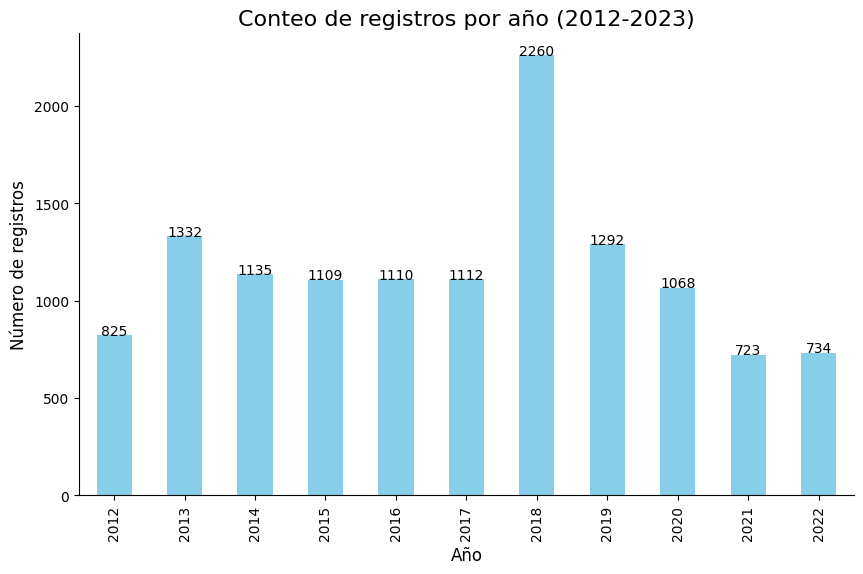

In [53]:
# Agrupar los datos por 'AÑO' y contar cuántos registros hay por cada año
conteo_por_año = subterraneo['AÑO'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
conteo_por_año.plot(kind='bar', color='skyblue')

# Configurar el título y las etiquetas de los ejes
plt.title('Conteo de registros por año (2012-2023)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Número de registros', fontsize=12)

# Mostrar los valores de las barras encima de cada barra
for index, value in enumerate(conteo_por_año):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10)

# Ocultar los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar el gráfico
plt.show()


In [54]:
#Codigo para sacar el total de muestras descargadas
#solo del 2012 al 2021, el conjunto de datos es del 2012 al 2023
#por lo tanto se tiene que excluir el año 2022 y el 2023 y crear
#un nuevo dataframe que se llame subterraneo_2012_2021 y obtendremos
#el total de muestras de ese periodo

In [55]:
#Despues de ese conjunto de datos se crea un dataframe que llamaremos
#subterraneo_2012_2021 y a ese dataframe hay que aplicarle el
#dropna para que nos de el resultado de total de muestras limpias

###Otras estadisticas

In [56]:
# Agrupar por año y contar los valores de la columna "Water quality" para cada grupo
conteo_por_año = df_subterraneo_calidad_del_agua.groupby('AÑO')['Calidad del agua'].value_counts().unstack(fill_value=0)

# Definir los nombres de las columnas
nombres_columnas = ['Good', 'Regular', 'Poor']

# Asignar los nombres a las columnas del dataframe
conteo_por_año.columns = nombres_columnas

# Mostrar el resultado
conteo_por_año

,Good,Regular,Poor
AÑO,,,
2012,5,1,7
2013,139,69,106
2014,352,184,302
2015,443,199,299
2016,449,188,365
2017,496,195,364
2018,915,370,791
2019,488,197,564
2020,427,247,382


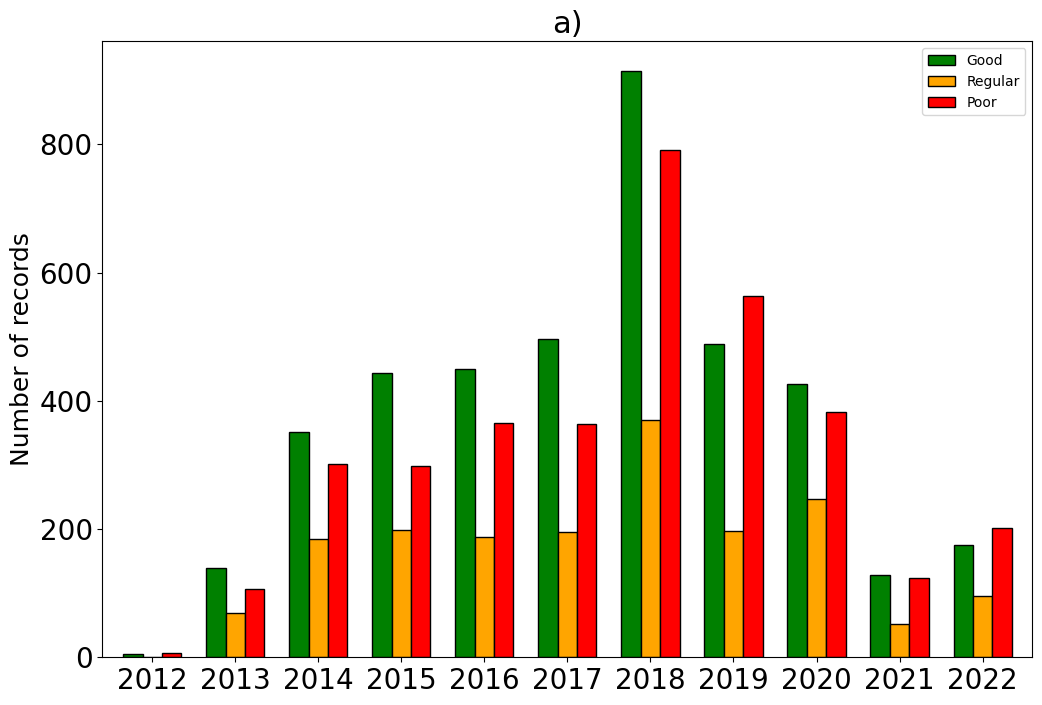

In [57]:
# Crear el DataFrame con tus datos
data = conteo_por_año  # Esto asume que ya tienes los datos de conteo_por_año
index = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]  # Los años disponibles
df = pd.DataFrame(data, index=index)

# Definir una lista de colores para cada categoría
colores = {
    'Good': 'green',
    'Regular': 'orange',
    'Poor': 'red'
}

# Graficar
df.plot(kind='bar', figsize=(12, 8), color=[colores[categoria] for categoria in df.columns], edgecolor='black', width=0.7)

# Configuración de etiquetas y título
plt.title('a)', fontsize=22)  # Título
plt.xlabel('', fontsize=20)  # Etiqueta del eje X
plt.ylabel('Number of records', fontsize=18)  # Etiqueta del eje Y

# Ajustar el tamaño de las etiquetas del eje X e Y
plt.xticks(rotation=0, fontsize=20)  # Etiquetas del eje X
plt.yticks(fontsize=20)  # Etiquetas del eje Y

# Mostrar el gráfico
plt.show()


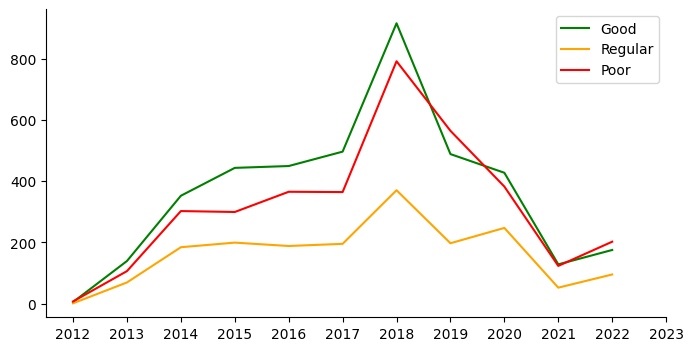

In [58]:
# Crear un rango de años de 2012 a 2023
rango_anos = pd.Index(range(2012, 2023))

# Asegurarse de que todos los años estén presentes, incluso si faltan datos
conteo_por_año = conteo_por_año.reindex(rango_anos, fill_value=0)

# Trazar las tres líneas en la misma figura
plt.figure(figsize=(8, 4))

# Colores: Verde para 'Buena', Naranja para 'Regular', Rojo para 'Mala'
conteo_por_año['Good'].plot(kind='line', color='green', label='Good')
conteo_por_año['Regular'].plot(kind='line', color='orange', label='Regular')
conteo_por_año['Poor'].plot(kind='line', color='red', label='Poor')

# Configurar el título y etiquetas de los ejes
plt.title('')
plt.xlabel('')
plt.ylabel('')

# Asegurarse de que los años del 2012 al 2023 aparezcan en el eje x
plt.xticks(rotation=0, fontsize=10, ticks=range(2012, 2024), labels=range(2012, 2024))

# Ocultar los bordes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [59]:
conteo_por_año = conteo_por_año.T

In [60]:
# Obtener el número de valores de la clase Good para el año seleccionado
año = 2015
registros_good = conteo_por_año.loc['Good', año]
print(f"Número de valores de la clase Good en el año {año}:", registros_good)

Número de valores de la clase Good en el año 2015: 443


In [61]:
# Obtener el número de valores de la clase Regular para el año seleccionado
año = 2015
registros_regular = conteo_por_año.loc['Regular', año]
print(f"Número de valores de la clase Regular en el año {año}:", registros_regular)

Número de valores de la clase Regular en el año 2015: 199


In [62]:
# Obtener el número de valores de la clase Good para el año seleccionado
año = 2015
registros_poor = conteo_por_año.loc['Poor', año]
print(f"Número de valores de la clase Poor en el año {año}:", registros_poor)

Número de valores de la clase Poor en el año 2015: 299


##Statistical Analysis of Groundwater Body

###Union de dataframes

In [63]:
# Unir los DataFrames a través de la columna "CLAVE SITIO"
subterraneo_contaminants_combined = pd.merge(
    subterraneo_preprocesado,  # DataFrame principal
    subterraneo_sites[['CLAVE SITIO', 'ORGANISMO CUENCA']],  # Seleccionar solo las columnas necesarias del otro DataFrame
    on='CLAVE SITIO',  # Columna común para realizar la unión
    how='left'  # Tipo de unión: 'left' conserva todos los registros del DataFrame principal
)

# Mostrar el DataFrame resultante
#print(subterraneo_contaminants_combined)


In [64]:
subterraneo_contaminants_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   f

In [65]:
# Filtrar valores entre 2012 y 2022 (inclusive)
subterraneo_contaminants_combined_2022 = subterraneo_contaminants_combined[(subterraneo_contaminants_combined['AÑO'] >= 2012) & (subterraneo_contaminants_combined['AÑO'] <= 2022)]

In [66]:
subterraneo_contaminants_combined_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          9319 non-null   object 
 1   CLAVE MONITOREO      9319 non-null   object 
 2   NOMBRE DEL SITIO     9319 non-null   object 
 3   TIPO CUERPO DE AGUA  9319 non-null   object 
 4   FECHA REALIZACIÓN    9319 non-null   object 
 5   AÑO                  9319 non-null   object 
 6   Alc_Tot              9319 non-null   float64
 7   Cond_elec            9319 non-null   float64
 8   Dur_Tot              9319 non-null   float64
 9   SDT                  9319 non-null   float64
 10  Fe_Tot               9319 non-null   float64
 11  Mn_Tot               9319 non-null   float64
 12  Fluo                 9319 non-null   float64
 13  CF                   9319 non-null   float64
 14  N_NO3                9319 non-null   float64
 15  As_Tot               9319 non-null   f

###No cumplimiento

####Porcentaje de no cumplimiento por contaminante y cuenca

In [67]:
df2 = subterraneo_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits2 = {
    'Alc_Tot': lambda x: not (20 <= x <= 400),
    'Cond_elec': lambda x: x > 2000,
    'Dur_Tot': lambda x: x > 500,
    'SDT': lambda x: x > 2000,
    'Fe_Tot': lambda x: x > 0.30,
    'Mn_Tot': lambda x: x > 0.15,
    'Fluo': lambda x: x >= 1.5,
    'CF': lambda x: x > 1000,
    'N_NO3': lambda x: x > 11,
    'As_Tot': lambda x: x > 0.025,
    'Cd_Tot': lambda x: x > 0.005,
    'Cr_Tot': lambda x: x > 0.05,
    'Hg_Tot': lambda x: x > 0.006,
    'Pb_Tot': lambda x: x > 0.01
}

# Crear una columna de no cumplimiento para cada parámetro
for col, condition in limits2.items():
    df2[f'{col}_no_cumple'] = df2[col].apply(condition)

# Calcular el porcentaje de no cumplimiento por parámetro para cada cuenca
non_compliance_summary = pd.DataFrame()
for col in limits2.keys():
    non_compliance_summary[col] = df2.groupby('ORGANISMO CUENCA')[f'{col}_no_cumple'].mean() * 100

# Mostrar el DataFrame con los resultados de no cumplimiento
non_compliance_summary.to_excel('porcentaje_subterraneo_no_cumplimiento_limites.xlsx')

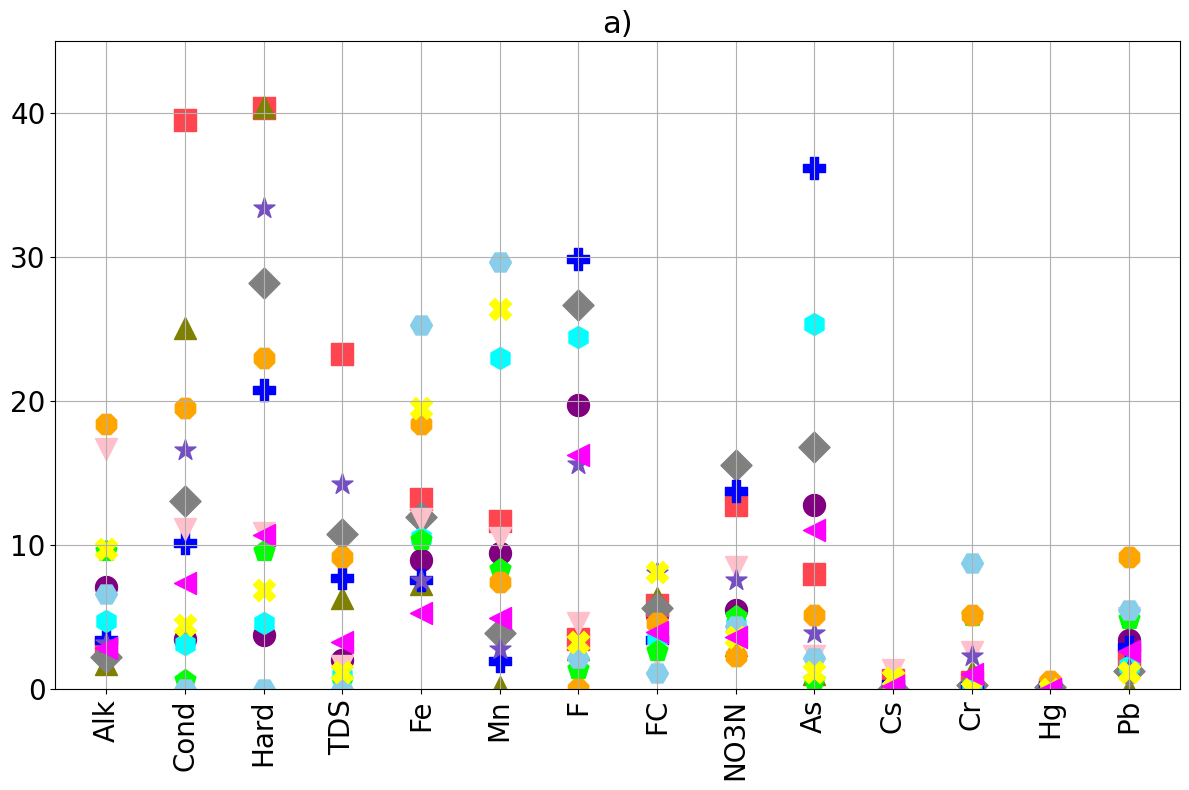

In [68]:
# Copia del DataFrame
df2 = subterraneo_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits2 = {
    'Alc_Tot': lambda x: x >= 20 and x <= 400,
    'Cond_elec': lambda x: x <= 2000,
    'Dur_Tot': lambda x: x <= 500,
    'SDT': lambda x: x <= 2000,
    'Fe_Tot': lambda x: x <= 0.30,
    'Mn_Tot': lambda x: x <= 0.15,
    'Fluo': lambda x: x < 1.5,
    'CF': lambda x: x <= 1000,
    'N_NO3': lambda x: x <= 11,
    'As_Tot': lambda x: x <= 0.025,
    'Cd_Tot': lambda x: x <= 0.005,
    'Cr_Tot': lambda x: x <= 0.05,
    'Hg_Tot': lambda x: x <= 0.006,
    'Pb_Tot': lambda x: x <= 0.01
}

# Crear una columna de cumplimiento para cada parámetro
for col, condition in limits2.items():
    df2[f'{col}'] = df2[col].apply(condition)

# Calcular el porcentaje de no cumplimiento por parámetro para cada cuenca
compliance_summary2 = pd.DataFrame()
for col in limits2.keys():
    compliance_summary2[col] = df2.groupby('ORGANISMO CUENCA')[f'{col}'].mean() * 100

# Diccionario para renombrar las columnas en el gráfico
nombres_columnas_grafico = {
    'Alc_Tot': 'Alk',
    'Cond_elec': 'Cond',
    'Dur_Tot': 'Hard',
    'SDT': 'TDS',
    'Fe_Tot': 'Fe',
    'Mn_Tot': 'Mn',
    'Fluo': 'F',
    'CF': 'FC',
    'N_NO3': 'NO3N',
    'As_Tot': 'As',
    'Cd_Tot': 'Cs',
    'Cr_Tot': 'Cr',
    'Hg_Tot': 'Hg',
    'Pb_Tot': 'Pb'
}

# Diccionario de colores y formas por cuenca
cuencas2 = {
    'LERMA SANTIAGO PACÍFICO': ('#800080', 'o'),
    'PENÍNSULA DE BAJA CALIFORNIA': ('#FF4550', 's'),
    'PENÍNSULA DE YUCATÁN': ('#808000', '^'),
    'RÍO BRAVO': ('#808080', 'D'),
    'CUENCAS CENTRALES DEL NORTE': ('#0000FF', 'P'),
    'PACÍFICO NORTE': ('#00FFFF', 'h'),
    'AGUAS DEL VALLE DE MÉXICO': ('#FFC0CB', 'v'),
    'BALSAS': ('#00FF00', 'p'),
    'GOLFO NORTE': ('#744EC2', '*'),
    'PACÍFICO SUR': ('#87CEEB', 'H'),
    'GOLFO CENTRO': ('#FFA500', '8'),
    'FRONTERA SUR': ('#FFFF00', 'X'),
    'NOROESTE': ('#FF00FF', '<'),
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Plotear los puntos para cada cuenca y parámetro
for cuenca in cuencas2:
    for j, col in enumerate(limits2.keys()):
        color, marker = cuencas2.get(cuenca, ('gray', 'o'))  # Obtener el color y la forma correspondientes
        ax.scatter(
            [nombres_columnas_grafico[col]],  # Usar el nombre renombrado
            [100 - compliance_summary2.loc[cuenca, col]],
            marker=marker,
            color=color,
            label=f'{cuenca}' if j == 0 else "",
            s=250  # Tamaño del punto
        )

# Configuración del eje Y
ax.set_ylim(0, 45)
ax.set_yticks([0, 10, 20, 30, 40])
ax.set_ylabel('', fontsize=20)

# Cambiar el tamaño de fuente de las etiquetas del eje Y
ax.tick_params(axis='y', labelsize=20)

# Configuración del eje X
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_xticks(list(nombres_columnas_grafico.values()))  # Usar los nombres renombrados
ax.set_xticklabels(list(nombres_columnas_grafico.values()), fontsize=20, rotation=90)
ax.tick_params(axis='x', labelsize=20)  # Tamaño de fuente del eje X

# Título y leyenda
ax.set_title('a)', fontsize=22)

# Ajustar la leyenda para evitar duplicados y posicionarla fuera del gráfico
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(), title='% Sites Exceeding Limits', title_fontsize=14, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=7)

plt.grid(True)
plt.tight_layout()
plt.show()


####Número total de registros de no cumplimiento por contaminante y cuenca

In [69]:
df1 = subterraneo_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits1 = {
    'Alc_Tot': lambda x: not (x >= 20 and x <= 400),
    'Cond_elec': lambda x: x > 2000,
    'Dur_Tot': lambda x: x > 500,
    'SDT': lambda x: x > 2000,
    'Fe_Tot': lambda x: x > 0.30,
    'Mn_Tot': lambda x: x > 0.15,
    'Fluo': lambda x: x >= 1.5,
    'CF': lambda x: x > 1000,
    'N_NO3': lambda x: x > 11,
    'As_Tot': lambda x: x > 0.025,
    'Cd_Tot': lambda x: x > 0.005,
    'Cr_Tot': lambda x: x > 0.05,
    'Hg_Tot': lambda x: x > 0.006,
    'Pb_Tot': lambda x: x > 0.01
}

# Crear una columna de no cumplimiento para cada parámetro
for col, condition in limits1.items():
    df1[f'{col}_no_cumple'] = df1[col].apply(condition)

# Calcular el número total de no cumplimiento por parámetro para cada cuenca
non_compliance_summary1 = pd.DataFrame()
for col in limits1.keys():
    non_compliance_summary1[col] = df1.groupby('ORGANISMO CUENCA')[f'{col}_no_cumple'].sum()

# Mostrar el DataFrame con los resultados de no cumplimiento
non_compliance_summary1.to_excel('total_subterraneo_no_cumplimiento_limites.xlsx')

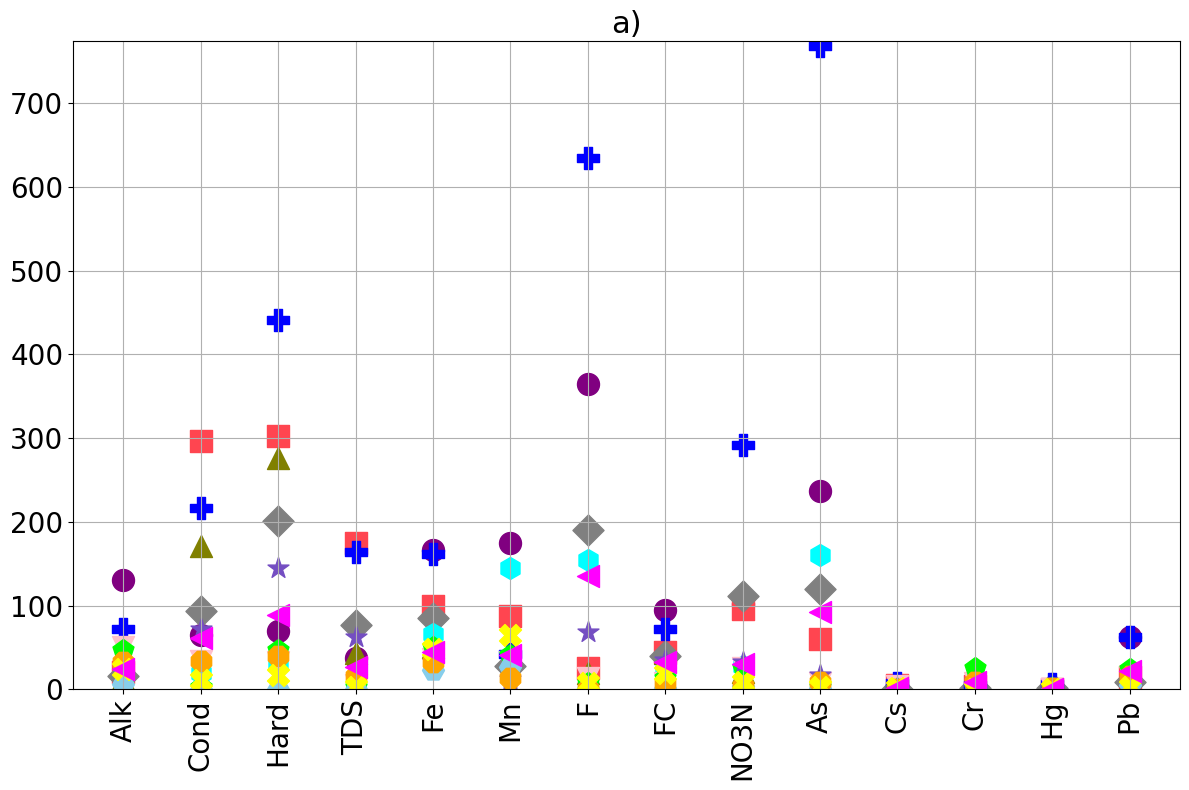

In [70]:
df1 = subterraneo_contaminants_combined_2022.copy()

# Definir los límites con funciones lambda
limits1 = {
    'Alc_Tot': lambda x: x >= 20 and x <= 400,
    'Cond_elec': lambda x: x <= 2000,
    'Dur_Tot': lambda x: x <= 500,
    'SDT': lambda x: x <= 2000,
    'Fe_Tot': lambda x: x <= 0.30,
    'Mn_Tot': lambda x: x <= 0.15,
    'Fluo': lambda x: x < 1.5,
    'CF': lambda x: x <= 1000,
    'N_NO3': lambda x: x <= 11,
    'As_Tot': lambda x: x <= 0.025,
    'Cd_Tot': lambda x: x <= 0.005,
    'Cr_Tot': lambda x: x <= 0.05,
    'Hg_Tot': lambda x: x <= 0.006,
    'Pb_Tot': lambda x: x <= 0.01
}

# Crear una columna de cumplimiento para cada parámetro
for col, condition in limits1.items():
    df1[f'{col}'] = df1[col].apply(condition)

# Calcular el número total de no cumplimiento por parámetro para cada cuenca
non_compliance_summary1 = pd.DataFrame()
for col in limits1.keys():
    non_compliance_summary1[col] = df1.groupby('ORGANISMO CUENCA')[f'{col}'].apply(lambda x: x.size - x.sum())

# Diccionario para renombrar las columnas en el gráfico
column_names_mapping = {
    'Alc_Tot': 'Alk',
    'Cond_elec': 'Cond',
    'Dur_Tot': 'Hard',
    'SDT': 'TDS',
    'Fe_Tot': 'Fe',
    'Mn_Tot': 'Mn',
    'Fluo': 'F',
    'CF': 'FC',
    'N_NO3': 'NO3N',
    'As_Tot': 'As',
    'Cd_Tot': 'Cs',
    'Cr_Tot': 'Cr',
    'Hg_Tot': 'Hg',
    'Pb_Tot': 'Pb'
}

# Crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Asumiendo que cuencas_colors_markers es tu diccionario de asignación de colores y formas para cada cuenca
cuencas1 = {
    'LERMA SANTIAGO PACÍFICO': ('#800080', 'o'),
    'PENÍNSULA DE BAJA CALIFORNIA': ('#FF4550', 's'),
    'PENÍNSULA DE YUCATÁN': ('#808000', '^'),
    'RÍO BRAVO': ('#808080', 'D'),
    'CUENCAS CENTRALES DEL NORTE': ('#0000FF', 'P'),
    'PACÍFICO NORTE': ('#00FFFF', 'h'),
    'AGUAS DEL VALLE DE MÉXICO': ('#FFC0CB', 'v'),
    'BALSAS': ('#00FF00', 'p'),
    'GOLFO NORTE': ('#744EC2', '*'),
    'PACÍFICO SUR': ('#87CEEB', 'H'),
    'GOLFO CENTRO': ('#FFA500', '8'),
    'FRONTERA SUR': ('#FFFF00', 'X'),
    'NOROESTE': ('#FF00FF', '<'),
}

# Plotear los puntos para cada cuenca y parámetro
for cuenca in cuencas1:
    for j, col in enumerate(limits1.keys()):
        color, marker = cuencas1.get(cuenca, ('gray', 'o'))  # Obtener el color y la forma correspondientes
        ax.scatter(
            [column_names_mapping[col]],
            [non_compliance_summary1.loc[cuenca, col]],
            marker=marker,
            color=color,
            label=f'{cuenca}' if j == 0 else "",
            s=250
        )

# Configuración del eje Y
ax.set_ylim(0, non_compliance_summary1.values.max() + 5)
ax.set_ylabel('', fontsize=20)

# Cambiar el tamaño de fuente de las etiquetas del eje Y
ax.tick_params(axis='y', labelsize=20)

# Configuración del eje X
ax.set_xlabel('', fontsize=14, fontweight='bold')
ax.set_xticks(list(column_names_mapping.values()))
ax.set_xticklabels(list(column_names_mapping.values()), fontsize=20, rotation=90)

# Título y leyenda
ax.set_title('a)', fontsize=22)

# Ajustar la leyenda para evitar duplicados y posicionarla fuera del gráfico
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#ax.legend(by_label.values(), by_label.keys(), title='Cuencas', title_fontsize=14, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4)

plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9319 entries, 0 to 9318
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   CLAVE SITIO          9319 non-null   object
 1   CLAVE MONITOREO      9319 non-null   object
 2   NOMBRE DEL SITIO     9319 non-null   object
 3   TIPO CUERPO DE AGUA  9319 non-null   object
 4   FECHA REALIZACIÓN    9319 non-null   object
 5   AÑO                  9319 non-null   object
 6   Alc_Tot              9319 non-null   bool  
 7   Cond_elec            9319 non-null   bool  
 8   Dur_Tot              9319 non-null   bool  
 9   SDT                  9319 non-null   bool  
 10  Fe_Tot               9319 non-null   bool  
 11  Mn_Tot               9319 non-null   bool  
 12  Fluo                 9319 non-null   bool  
 13  CF                   9319 non-null   bool  
 14  N_NO3                9319 non-null   bool  
 15  As_Tot               9319 non-null   bool  
 16  Cd_Tot

##Data visualization

In [72]:
df_2012_al_2021_sp = df_2012_al_2021_sp.iloc[:, 6:20]
df_2012_al_2022_sp = df_2012_al_2022_sp.iloc[:, 6:20]
df_2012_al_2023_sp = df_2012_al_2023_sp.iloc[:, 6:20]

In [73]:
df_2012_al_2021_p = df_2012_al_2021_p.iloc[:, 6:20]
df_2012_al_2022_p = df_2012_al_2022_p.iloc[:, 6:20]
df_2012_al_2023_p = df_2012_al_2023_p.iloc[:, 6:20]

In [74]:
# Diccionario para renombrar las columnas
nombres_columnas = {
    'Alc_Tot': 'Alk',
    'Cond_elec': 'Cond',
    'Dur_Tot': 'Hard',
    'SDT': 'TDS',
    'Fe_Tot': 'Fe',
    'Mn_Tot': 'Mn',
    'Fluo': 'F',
    'CF': 'FC',
    'N_NO3': 'NO3N',
    'As_Tot': 'As',
    'Cd_Tot': 'Cd',
    'Cr_Tot': 'Cr',
    'Hg_Tot': 'Hg',
    'Pb_Tot': 'Pb'
}

# Renombrar las columnas
df_2012_al_2021_sp = df_2012_al_2021_sp.rename(columns=nombres_columnas)

# Renombrar las columnas
df_2012_al_2021_p = df_2012_al_2021_p.rename(columns=nombres_columnas)

###Mapa de calor de simbolos > y <

####al 2021

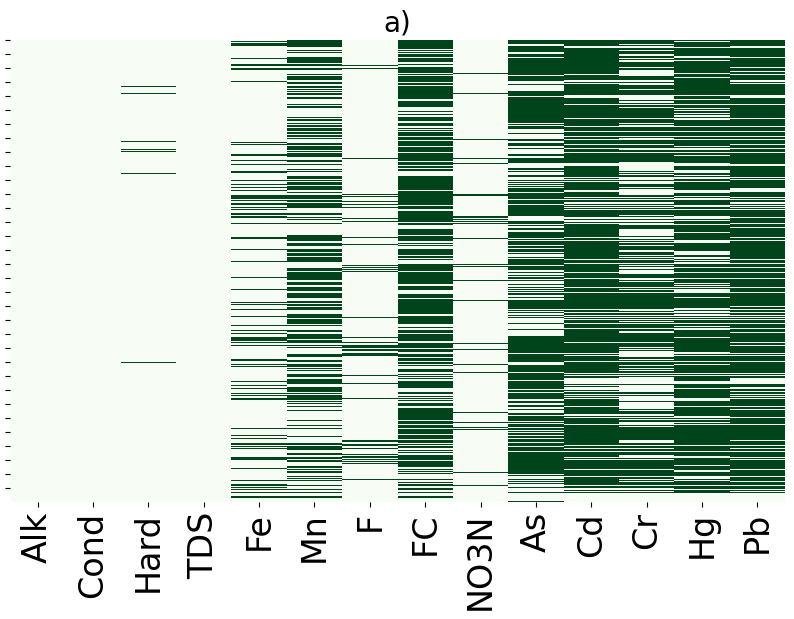

In [75]:
# Crear una matriz booleana donde True indica presencia de < o >
bool_matrix = df_2012_al_2021_sp.applymap(lambda x: '<' in str(x) or '>' in str(x))

# Crear un heatmap de la matriz booleana para todas las columnas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar el heatmap basado en la matriz booleana
heatmap = sns.heatmap(bool_matrix, cbar=False, cmap='Greens')  # Usar 'Greens'

# Rotar las etiquetas del eje X 90 grados y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje Y a una lista vacía para eliminarlas
heatmap.set_yticklabels([])

# Configurar el título y la etiqueta del eje X
plt.title('a)', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)

# Mostrar el heatmap
plt.show()


####al 2022

####al 2023

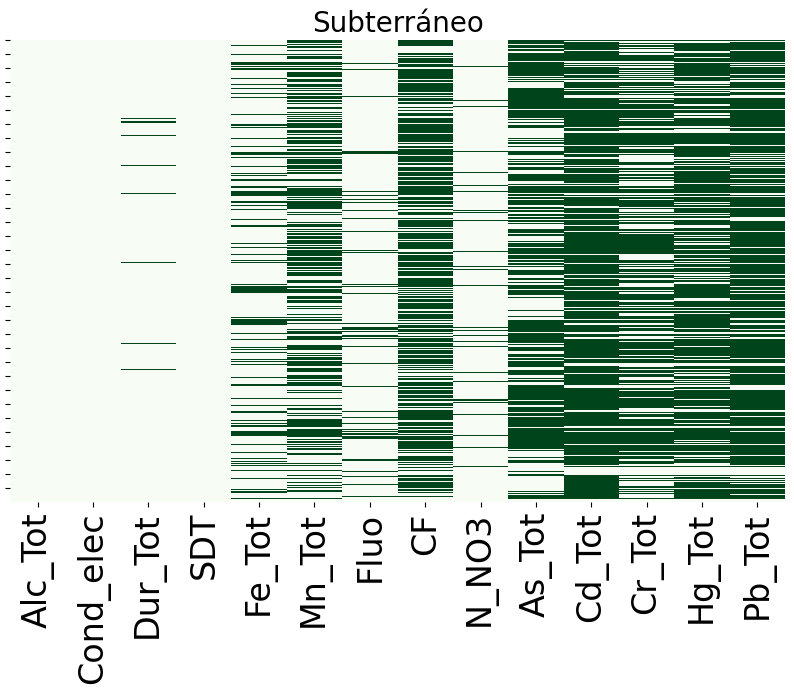

In [76]:
# Crear una matriz booleana donde True indica presencia de < o >
bool_matrix = df_2012_al_2023_sp.applymap(lambda x: '<' in str(x) or '>' in str(x))

# Crear un heatmap de la matriz booleana para todas las columnas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar el heatmap basado en la matriz booleana
heatmap = sns.heatmap(bool_matrix, cbar=False, cmap='Greens')  # Usar 'Greens'

# Rotar las etiquetas del eje X 90 grados y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje Y a una lista vacía para eliminarlas
heatmap.set_yticklabels([])

# Configurar el título y la etiqueta del eje X
plt.title('Subterráneo', loc='center', fontsize=20)
plt.xlabel('', loc='center', fontsize=20)

# Mostrar el heatmap
plt.show()


###Mapa de calor de valores nulos

####al 2021

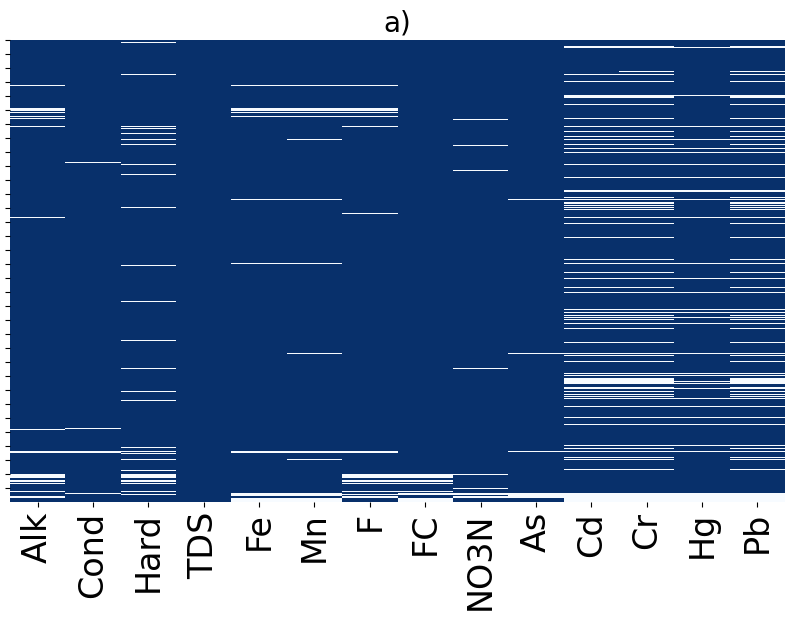

In [77]:
# Seleccionar las columnas que deseas incluir en el mapa de calor
columnas_seleccionadas_subterraneo = df_2012_al_2021_sp.columns  # Reemplaza con el rango de nombres de columnas que deseas

# Crear un mapa de calor de valores faltantes para todas las columnas del DataFrame
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Generar un mapa de calor mostrando la presencia de valores faltantes
heatmap = sns.heatmap(df_2012_al_2021_sp.isnull(), cbar=False, cmap='Blues_r')

# Rotar las etiquetas del eje x 90 grados para que sean verticales y aumentar el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establecer las etiquetas del eje y como una lista vacía para eliminarlas
heatmap.set_yticklabels([])

plt.title('a)', loc='center', fontsize=20)  # Título del gráfico
plt.xlabel('', loc='center', fontsize=20)  # Etiqueta del eje x
plt.show()  # Muestra el gráfico

####al 2022

####al_2023

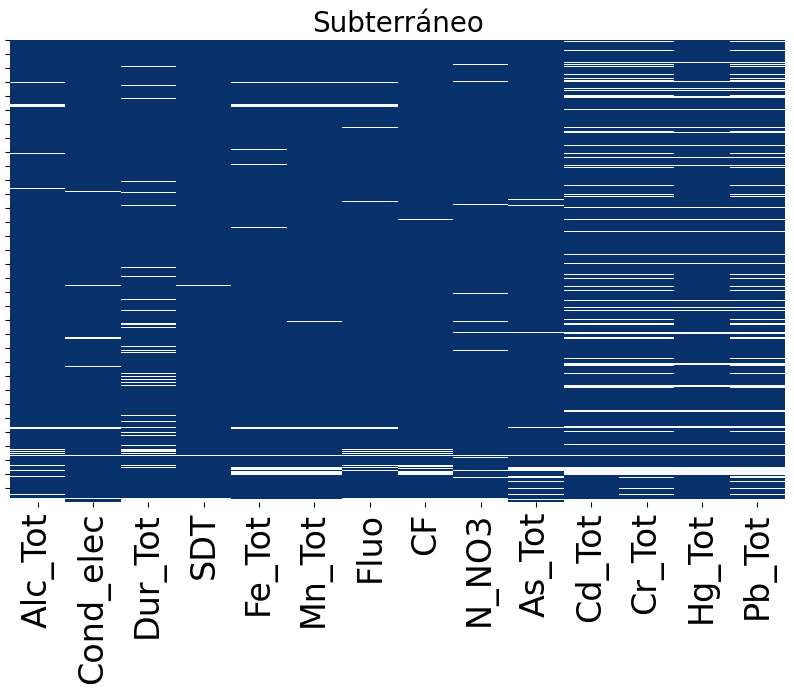

In [78]:
# Seleccionar las columnas que deseas incluir en el mapa de calor
columnas_seleccionadas_subterraneo = df_2012_al_2023_sp.columns  # Reemplaza con el rango de nombres de columnas que deseas

# Crear un mapa de calor de valores faltantes solo para las columnas seleccionadas
plt.figure(figsize=(10, 6))  # Ajustar el tamaño de la figura

# Genera un mapa de calor que muestra la presencia de valores faltantes en las columnas seleccionadas
heatmap = sns.heatmap(df_2012_al_2023_sp[columnas_seleccionadas_subterraneo].isnull(), cbar=False, cmap='Blues_r')

# Rotea las etiquetas del eje x 90 grados para que sean verticales y aumenta el tamaño de la fuente
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=24)

# Establece las etiquetas del eje y como una lista vacía para eliminarlas
heatmap.set_yticklabels([])

plt.title('Subterráneo', loc='center', fontsize=20)  # Título del gráfico
plt.xlabel('', loc='center', fontsize=20)  # Etiqueta del eje x
plt.show()  # Muestra el gráfico


###Mapa de calor de correlación de valores nulos entre contaminantes

####al 2021

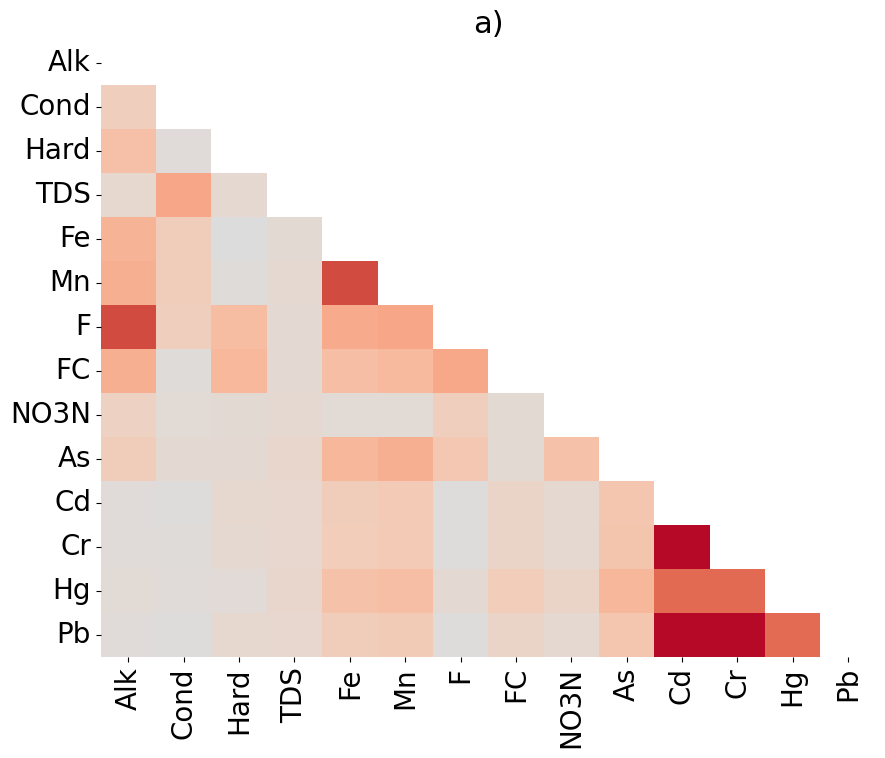

In [79]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2021_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('a)', fontsize=22)
plt.show()


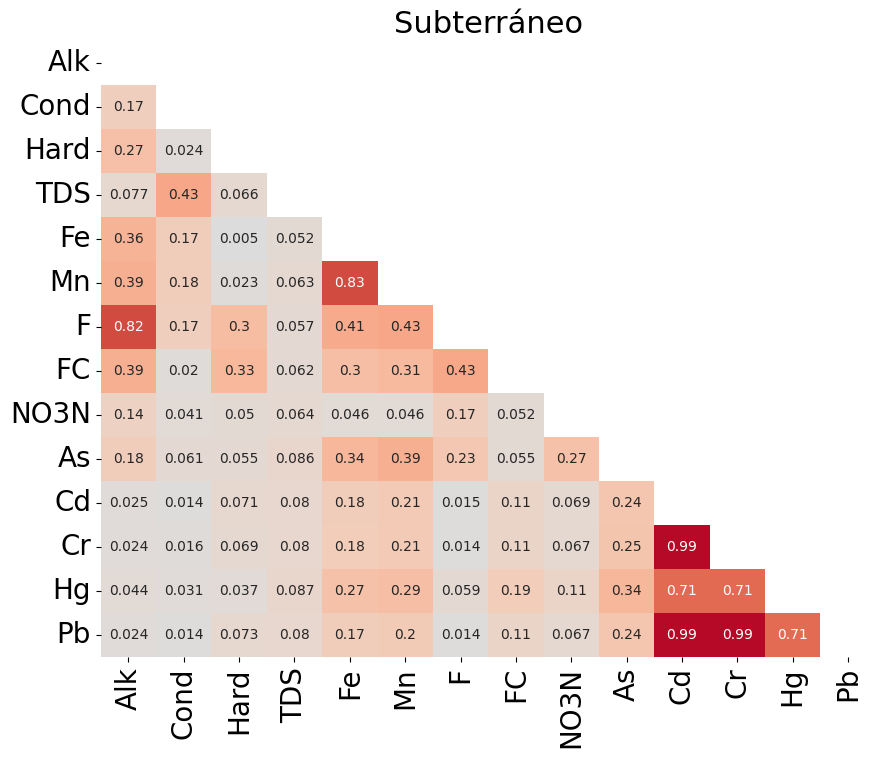

In [80]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2021_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo', fontsize=22)
plt.show()

####al 2022

####al 2023

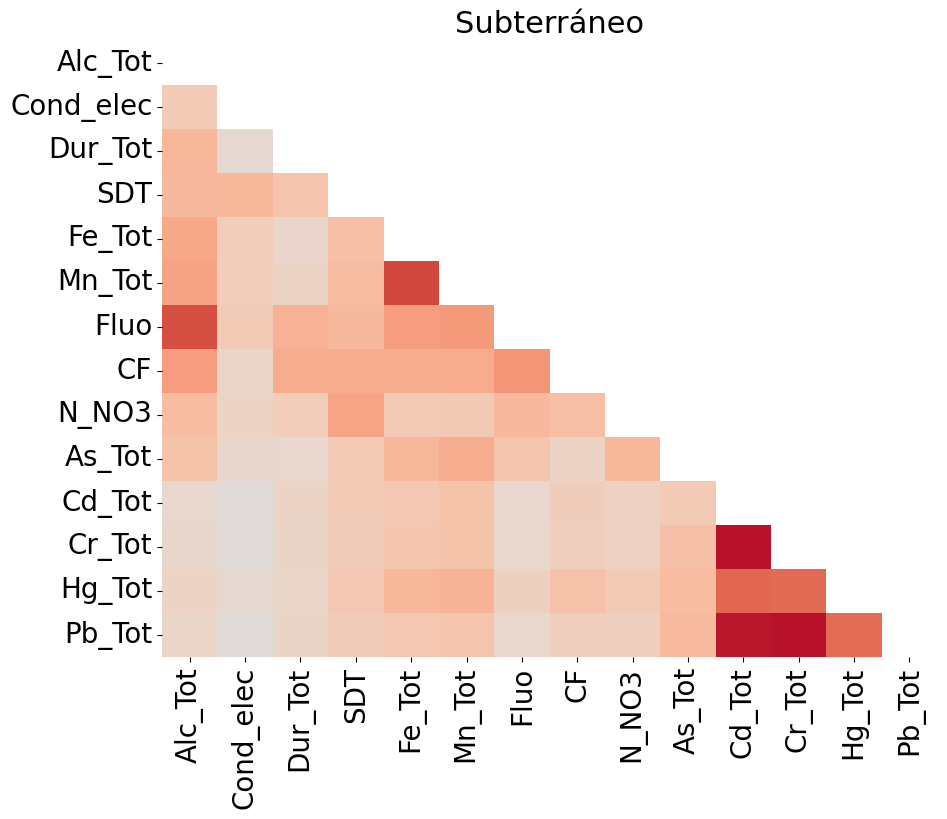

In [81]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2023_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo', fontsize=22)
plt.show()


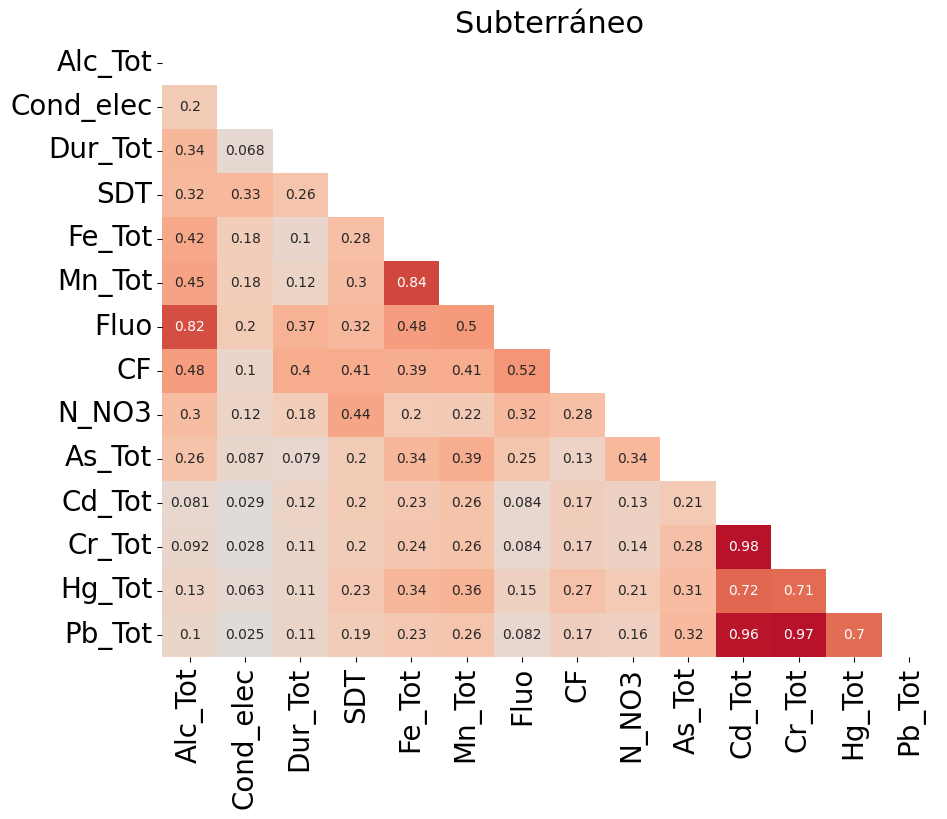

In [82]:
# Crear un DataFrame que indica dónde están los valores nulos
df = pd.DataFrame(df_2012_al_2023_sp)

# Calcular la correlación entre valores nulos
null_df = df.isnull()
null_corr_matrix = null_df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(null_corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(null_corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo', fontsize=22)
plt.show()

###Mapa de calor de correlación lineal

####al 2021

#####Coeficiente de correlación de Pearson

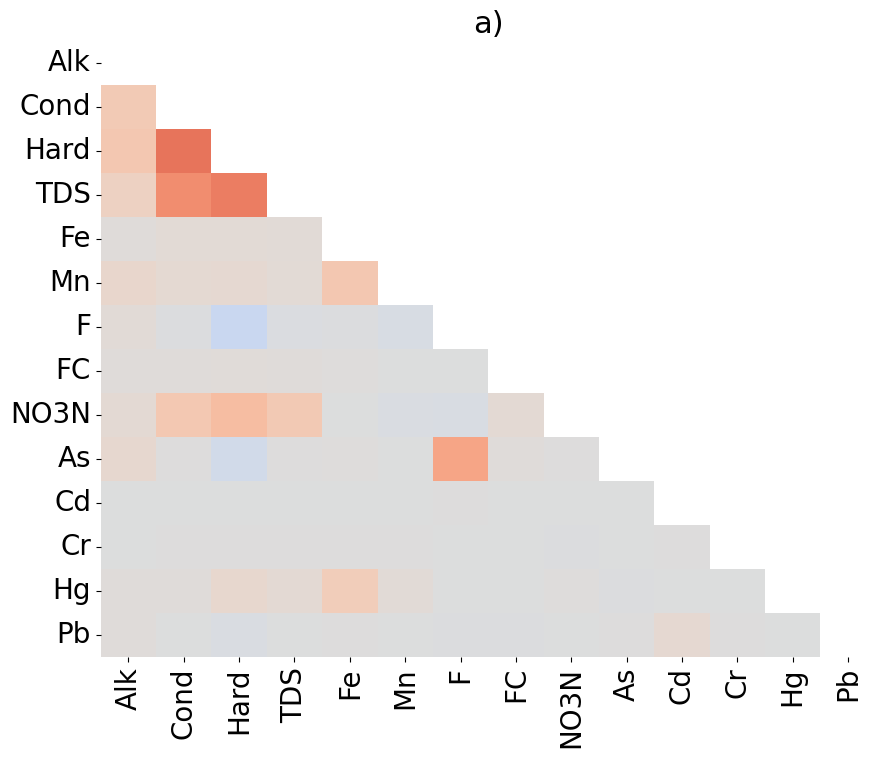

In [83]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('a)', fontsize=22)

# Mostrar el gráfico
plt.show()

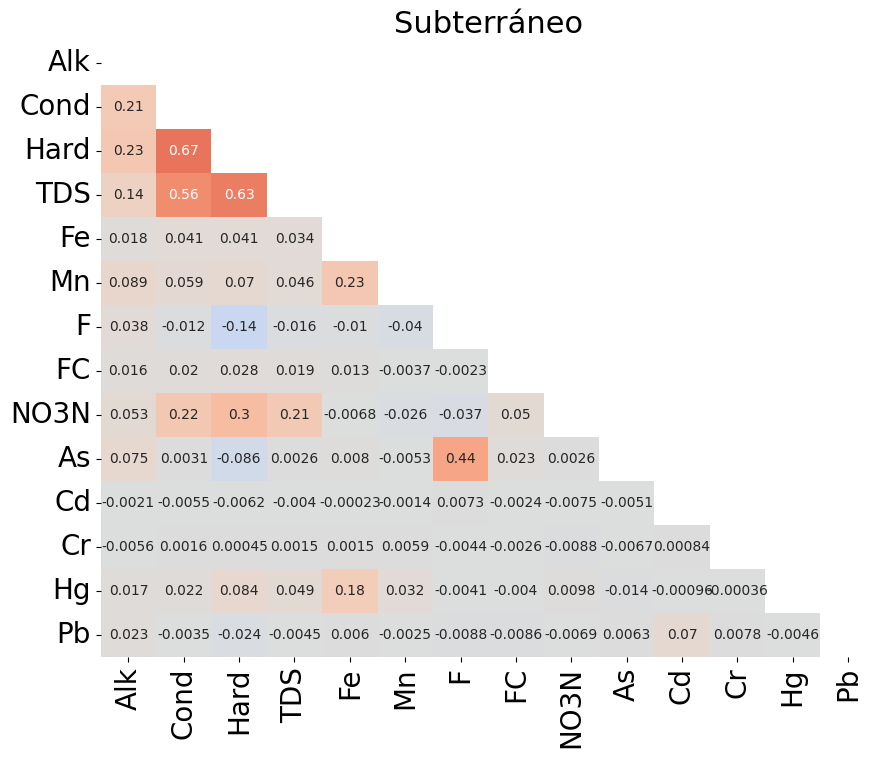

In [84]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo', fontsize=22)

# Mostrar el gráfico
plt.show()

#####Coeficiente de correlación de Spearman

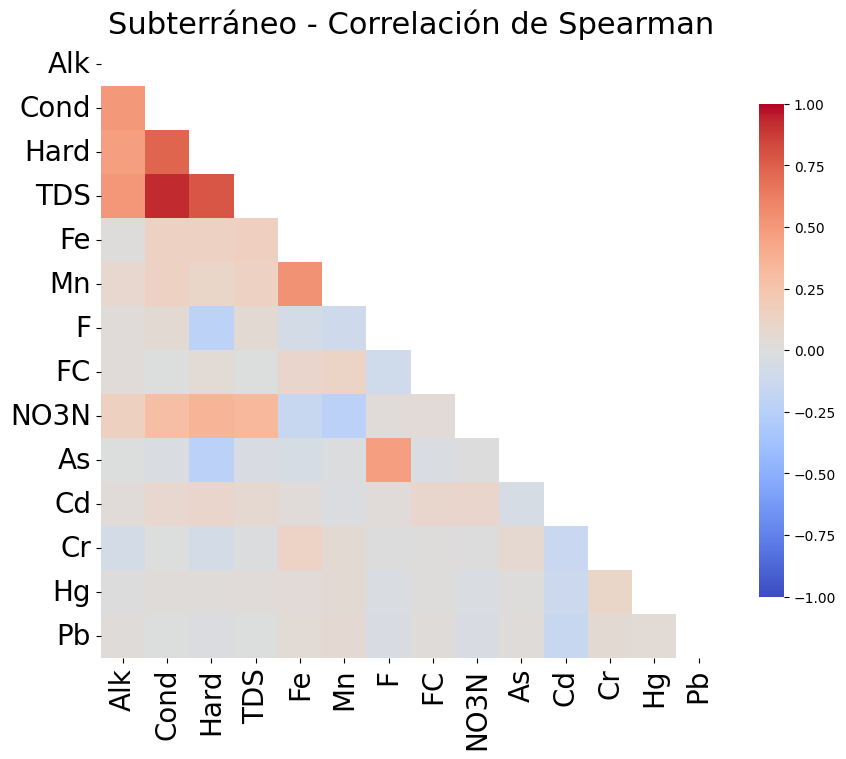

In [85]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


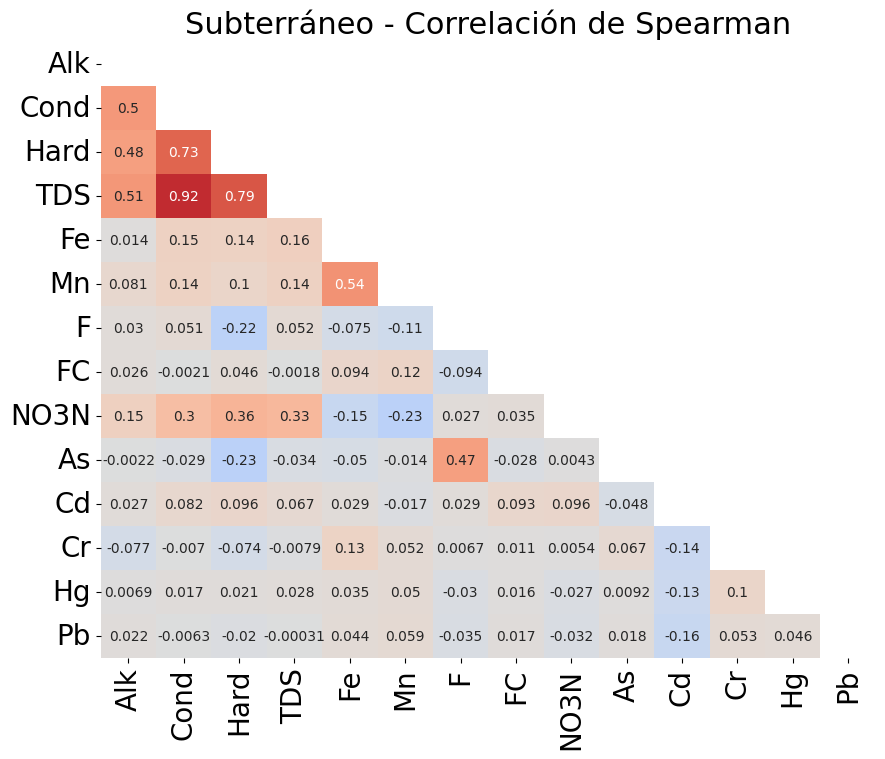

In [86]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2021_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


####al 2022

####al 2023

#####Coeficiente de correlación de Pearson

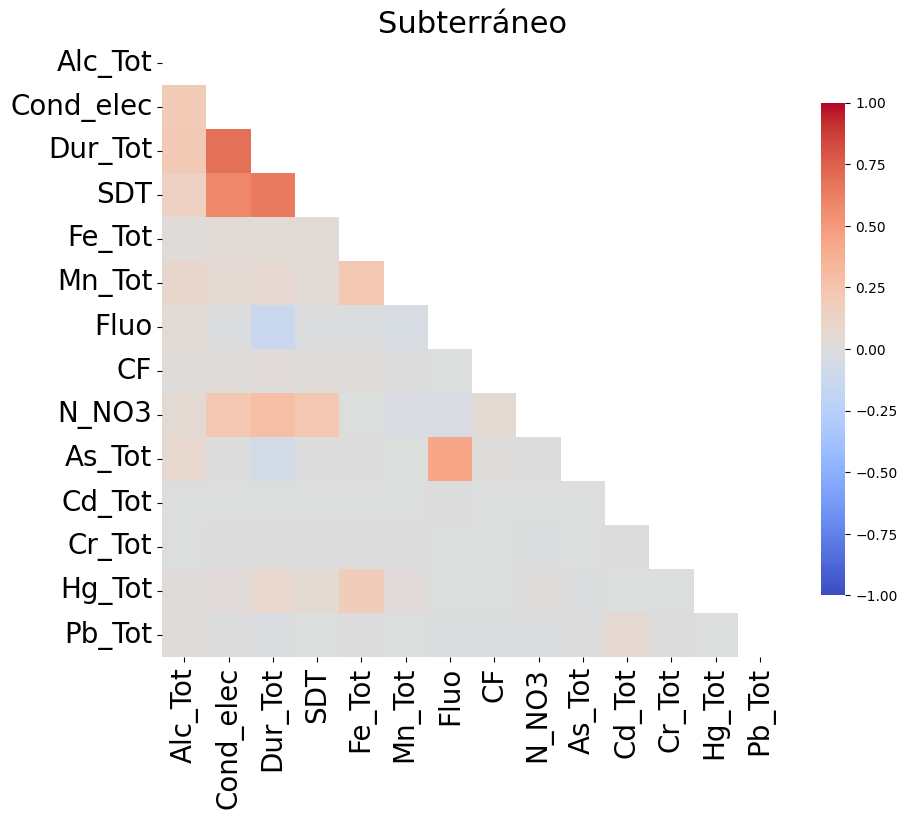

In [87]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo', fontsize=22)

# Mostrar el gráfico
plt.show()

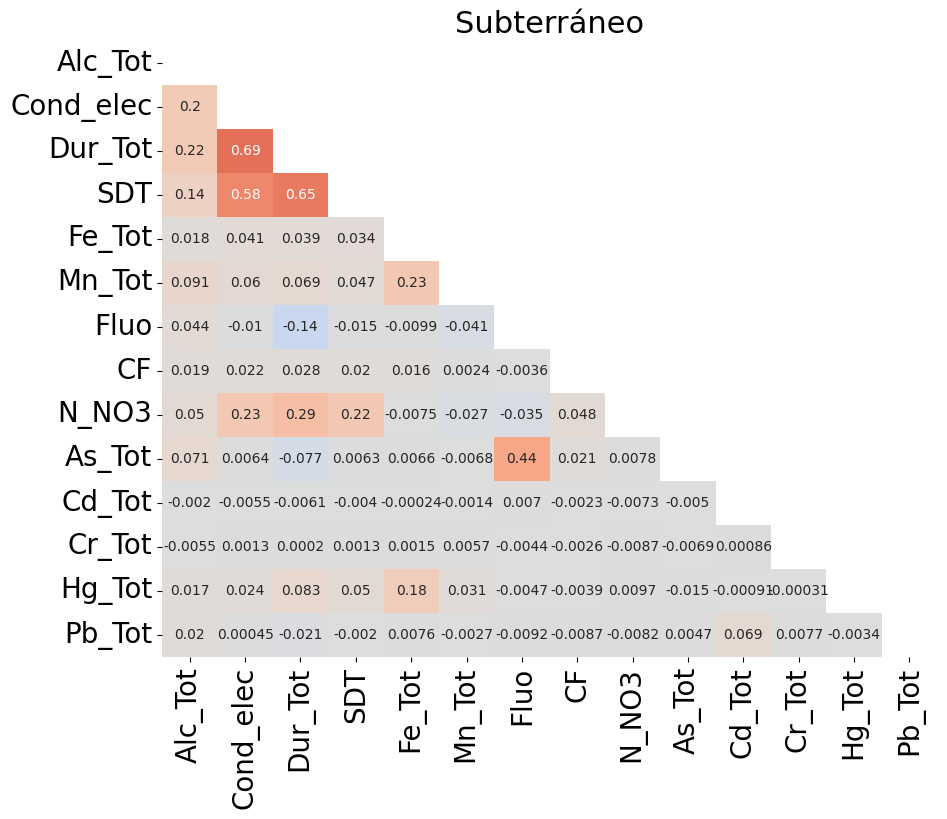

In [88]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación
corr_matrix = df.corr()

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo', fontsize=22)

# Mostrar el gráfico
plt.show()

#####Coeficiente de correlación de Spearman

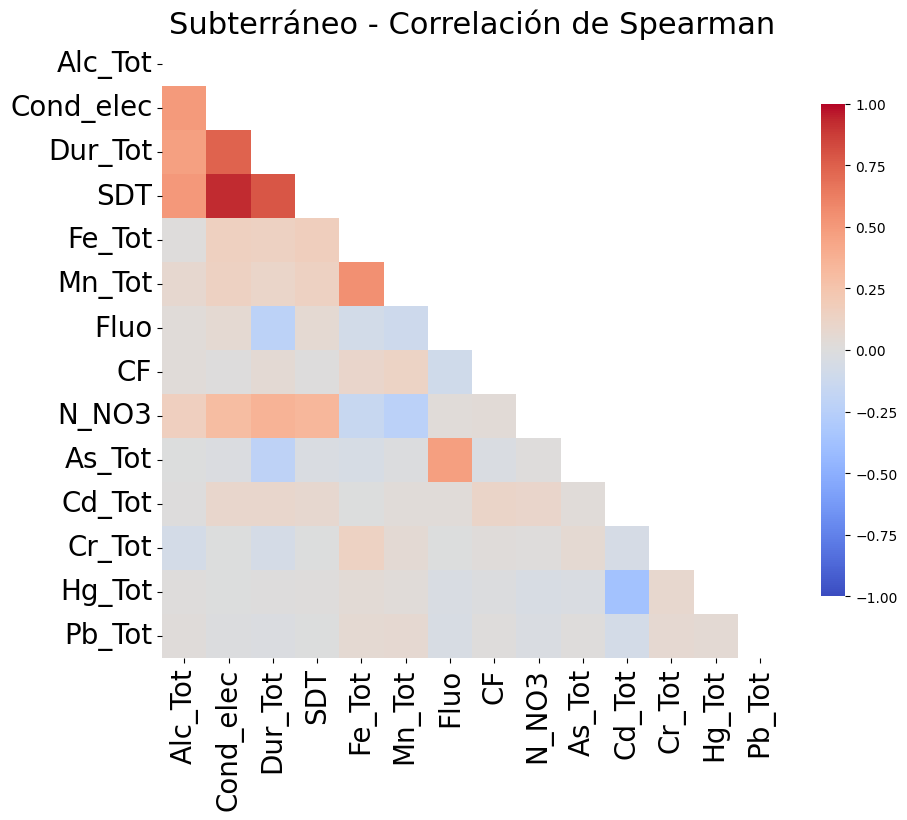

In [89]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


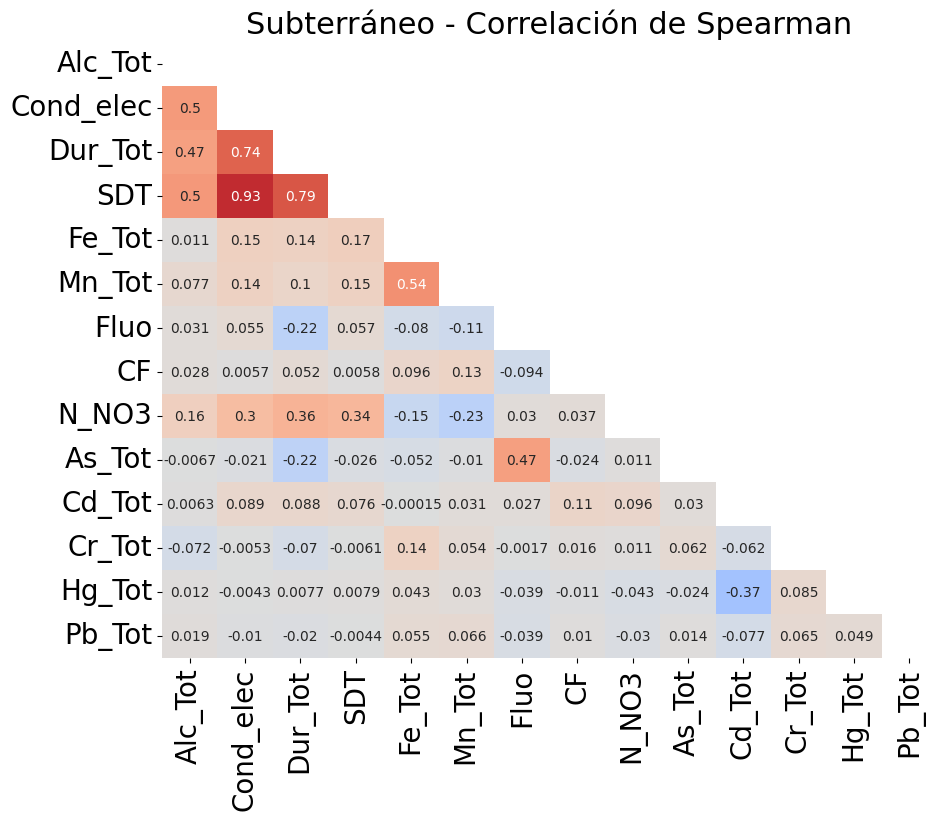

In [90]:
# Crear un DataFrame
df = pd.DataFrame(df_2012_al_2023_p)

# Calcular la matriz de correlación utilizando Spearman
corr_matrix = df.corr(method='spearman')

# Crear una máscara para la parte superior de la matriz de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Establecer el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Dibujar el mapa de calor con la máscara y los valores de correlación
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False, cbar_kws={'shrink': .8})

# Ajustar el tamaño y la rotación de las etiquetas del eje x y del eje y
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

# Añadir el título
plt.title('Subterráneo - Correlación de Spearman', fontsize=22)

# Mostrar el gráfico
plt.show()


###Mapa de calor de correlacion entre variables independientes y variable objetivo

####al 2021

Matriz de coeficientes Eta:
      Water quality
Alk        0.247457
Cond       0.321382
Hard       0.380738
TDS        0.267221
Fe         0.065475
Mn         0.157017
F          0.391594
FC         0.179522
NO3N       0.246933
As         0.380652
Cd         0.029731
Cr         0.027370
Hg         0.029925
Pb         0.118903


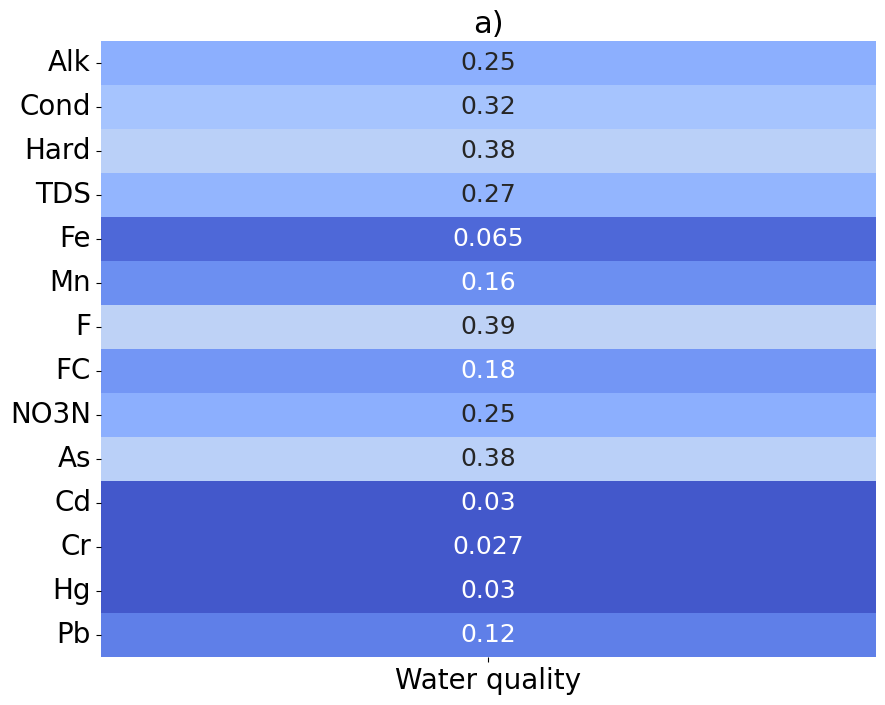

In [91]:
# Función para calcular el coeficiente Eta
def coeficiente_eta(categorica, numerica):
    categorias = categorica.unique()
    medias_grupo = numerica.groupby(categorica).mean()
    media_total = numerica.mean()

    # Suma de cuadrados entre grupos
    ss_between = sum(categorica.value_counts()[cat] * (medias_grupo[cat] - media_total)**2 for cat in categorias)
    # Suma de cuadrados totales
    ss_total = sum((numerica - media_total)**2)

    # Coeficiente Eta
    eta = np.sqrt(ss_between / ss_total)
    return eta

# Función para calcular y graficar el mapa de calor del coeficiente Eta
def graficar_coeficiente_eta(df, variable_categorica, variables_numericas, nombres_mostrados=None):
    # Si se proporcionan nombres renombrados, construir un diccionario para mapear
    if nombres_mostrados:
        nombres_dict = dict(zip(variables_numericas, nombres_mostrados))
    else:
        nombres_dict = {col: col for col in variables_numericas}  # Mismos nombres si no se proporcionan nuevos

    # Crear una matriz de coeficientes Eta
    eta_matrix = pd.DataFrame(index=nombres_mostrados if nombres_mostrados else variables_numericas,
                              columns=["Water quality"])  # Cambiar el título de la columna a "Water quality"

    for var in variables_numericas:
        eta_matrix.loc[nombres_dict[var], "Water quality"] = coeficiente_eta(df[variable_categorica], df[var])

    # Convertir a tipo float para visualización
    eta_matrix = eta_matrix.astype(float)

    # Imprimir los valores calculados
    print("Matriz de coeficientes Eta:")
    print(eta_matrix)

    # Crear un mapa de calor
    plt.figure(figsize=(10, 8))
    # Aumentar el tamaño de la letra de las anotaciones
    sns.heatmap(eta_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, cbar=False, cbar_kws={'shrink': 0.8},
                annot_kws={'size': 18})  # Puedes cambiar el valor de 'size' para hacer el texto más grande

    # Personalización del gráfico
    plt.title('a)', fontsize=22)
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.xlabel("", fontsize=20)  # Cambiar etiqueta del eje x
    plt.show()

# Ejemplo de uso con nombres personalizados:
graficar_coeficiente_eta(
    df=df_subterraneo_calidad_del_agua_2021,
    variable_categorica='Calidad del agua',
    variables_numericas=['Alc_Tot', 'Cond_elec', 'Dur_Tot', 'SDT', 'Fe_Tot', 'Mn_Tot', 'Fluo', 'CF', 'N_NO3', 'As_Tot', 'Cd_Tot', 'Cr_Tot', 'Hg_Tot', 'Pb_Tot'],
    nombres_mostrados=['Alk', 'Cond', 'Hard', 'TDS', 'Fe', 'Mn', 'F', 'FC', 'NO3N', 'As', 'Cd', 'Cr', 'Hg', 'Pb']
)


####al 2022

####al 2023

##Template

In [92]:
subterraneo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12700 entries, 0 to 12699
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          12700 non-null  object 
 1   CLAVE MONITOREO      12700 non-null  object 
 2   NOMBRE DEL SITIO     12700 non-null  object 
 3   TIPO CUERPO DE AGUA  12700 non-null  object 
 4   FECHA REALIZACIÓN    12700 non-null  object 
 5   AÑO                  12700 non-null  object 
 6   Alc_Tot              12074 non-null  float64
 7   Cond_elec            12497 non-null  float64
 8   Dur_Tot              11870 non-null  float64
 9   SDT                  12547 non-null  float64
 10  Fe_Tot               12095 non-null  float64
 11  Mn_Tot               12121 non-null  float64
 12  Fluo                 12155 non-null  float64
 13  CF                   12285 non-null  float64
 14  N_NO3                12348 non-null  float64
 15  As_Tot               12377 non-null 

In [93]:
subterraneo_template = subterraneo.copy()

In [94]:
# Filtrar el DataFrame original para que solo incluya las filas donde el año es 2022
subterraneo_template = subterraneo[subterraneo['AÑO'].isin([2022])]

In [95]:
subterraneo_template = subterraneo_template.reset_index(drop=True)

In [96]:
# Reemplazar los caracteres específicos en las columnas seleccionadas
columns = ['Alc_Tot', 'Cond_elec', 'Dur_Tot', 'SDT', 'Fe_Tot', 'Mn_Tot', 'Fluo', 'CF', 'N_NO3', 'As_Tot', 'Cd_Tot', 'Cr_Tot', 'Hg_Tot', 'Pb_Tot']  # Asegúrate de ajustar 'columns' según tus necesidades

# Usar .loc para evitar el SettingWithCopyWarning
subterraneo_template.loc[:, columns] = subterraneo_template[columns].replace({'<':'', '>':'', '≤':'', '≥':''}, regex=True)

In [97]:
subterraneo_template.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          734 non-null    object 
 1   CLAVE MONITOREO      734 non-null    object 
 2   NOMBRE DEL SITIO     734 non-null    object 
 3   TIPO CUERPO DE AGUA  734 non-null    object 
 4   FECHA REALIZACIÓN    734 non-null    object 
 5   AÑO                  734 non-null    object 
 6   Alc_Tot              603 non-null    float64
 7   Cond_elec            704 non-null    float64
 8   Dur_Tot              643 non-null    float64
 9   SDT                  614 non-null    float64
 10  Fe_Tot               633 non-null    float64
 11  Mn_Tot               626 non-null    float64
 12  Fluo                 637 non-null    float64
 13  CF                   628 non-null    float64
 14  N_NO3                602 non-null    float64
 15  As_Tot               587 non-null    flo

In [98]:
# Eliminar filas con valores nulos en las columnas 'Alk', 'Cond' y 'Hard'
subterraneo_template = subterraneo_template.dropna(subset=['Alc_Tot', 'Cond_elec', 'Dur_Tot', 'SDT', 'Fe_Tot', 'Mn_Tot', 'Fluo', 'CF', 'N_NO3', 'As_Tot', 'Cd_Tot', 'Cr_Tot', 'Hg_Tot', 'Pb_Tot'])

In [99]:
subterraneo_template.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 0 to 630
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CLAVE SITIO          472 non-null    object 
 1   CLAVE MONITOREO      472 non-null    object 
 2   NOMBRE DEL SITIO     472 non-null    object 
 3   TIPO CUERPO DE AGUA  472 non-null    object 
 4   FECHA REALIZACIÓN    472 non-null    object 
 5   AÑO                  472 non-null    object 
 6   Alc_Tot              472 non-null    float64
 7   Cond_elec            472 non-null    float64
 8   Dur_Tot              472 non-null    float64
 9   SDT                  472 non-null    float64
 10  Fe_Tot               472 non-null    float64
 11  Mn_Tot               472 non-null    float64
 12  Fluo                 472 non-null    float64
 13  CF                   472 non-null    float64
 14  N_NO3                472 non-null    float64
 15  As_Tot               472 non-null    float64


In [100]:
subterraneo_template.to_csv("subterraneo_template.csv")

##Model training

#####Separación de los datos en conjuntos de entrenamiento y prueba

In [101]:
# Crea un nuevo DataFrame para el entrenamiento del modelo con datos desde 2012 hasta 2021, excluyendo los años 2022 y 2023
train_subterraneo = data_subterraneo[(data_subterraneo['AÑO'] != 2022) & (data_subterraneo['AÑO'] != 2023)]

# Crea un nuevo DataFrame para validación que consiste únicamente en datos de los años 2022 y 2023
val_subterraneo = data_subterraneo[(data_subterraneo['AÑO'] == 2022) | (data_subterraneo['AÑO'] == 2023)]

In [102]:
# Selecciona columnas para el entrenamiento del modelo, incluyendo las columnas de contaminantes y la variable objetivo 'Calidad del agua' para el conjunto de datos de 2012 a 2021
train_subterraneo_num = train_subterraneo.iloc[:, list(range(6, 20)) + [48]]
train_subterraneo_num.head()

,Alc_Tot,Cond_elec,Dur_Tot,SDT,Fe_Tot,Mn_Tot,Fluo,CF,N_NO3,As_Tot,Cd_Tot,Cr_Tot,Hg_Tot,Pb_Tot,Calidad del agua
1,371.135,842.0,308.4032,538.88,0.8667,0.00720,0.815100,1.0,1.662100,0.0015,0.001301,0.0110,0.000100,0.00154,1
2,398.800,867.0,188.0000,582.00,0.0110,0.00021,0.857000,121.0,1.515000,0.0015,0.001301,0.0033,0.000201,0.00154,0
3,406.000,930.0,264.0100,604.00,0.0242,0.00021,0.809780,1.0,1.534100,0.0015,0.001301,0.0012,0.000201,0.00154,1
4,402.000,881.0,266.1600,612.00,0.0041,0.00021,0.796525,1.0,1.535676,0.0015,0.001301,0.0012,0.000201,0.00154,1
5,401.120,861.0,268.1046,576.00,0.0041,0.00021,0.702500,10.0,1.741013,0.0015,0.001301,0.0012,0.000160,0.00154,1


In [103]:
# Muestra el tamaño del DataFrame de entrenamiento
train_subterraneo_num.shape

(8847, 15)

In [104]:
# Selecciona columnas para el entrenamiento del modelo, incluyendo las columnas de contaminantes y la variable objetivo 'Calidad del agua' para el conjunto de datos del año 2022
val_subterraneo_num = val_subterraneo.iloc[:, list(range(6, 20)) + [48]]
val_subterraneo_num.head()

,Alc_Tot,Cond_elec,Dur_Tot,SDT,Fe_Tot,Mn_Tot,Fluo,CF,N_NO3,As_Tot,Cd_Tot,Cr_Tot,Hg_Tot,Pb_Tot,Calidad del agua
11966,176.8,548.0,188.0,322.0,0.0290,0.00200,0.50,10.0,3.843,0.0210,0.001301,0.0030,0.000201,0.00154,0
11967,168.4,378.0,152.0,247.4,0.0041,0.08800,0.55,10.0,0.295,0.0085,0.001301,0.0023,0.000201,0.00154,0
11968,204.4,564.0,238.0,400.8,0.0089,0.00021,0.53,10.0,4.296,0.0220,0.001301,0.0012,0.000201,0.00154,0
11969,203.4,540.0,220.0,384.4,0.0510,0.00300,0.47,10.0,1.748,0.0160,0.001301,0.0012,0.000201,0.00154,0
11970,206.8,551.0,216.0,387.8,0.0150,0.04900,0.52,10.0,1.058,0.0130,0.001301,0.0030,0.000201,0.00154,0


In [105]:
# Muestra el tamaño del DataFrame de validación
val_subterraneo_num.shape

(472, 15)

Separación de la variable dependiente (y) de las variables independientes (X)

In [106]:
# Separa las características (X_val_lotico) y la variable objetivo (y_val_lotico) para la validación
X_val_subterraneo_num = val_subterraneo_num.drop(columns=['Calidad del agua'])
y_val_subterraneo_num = val_subterraneo_num['Calidad del agua']

In [107]:
# Separa las características (X_val_lotico) y la variable objetivo (y_val_lotico) para la validación
X_train_subterraneo_num = train_subterraneo_num.drop(columns=['Calidad del agua'])
y_train_subterraneo_num = train_subterraneo_num['Calidad del agua']

In [108]:
X_train_subterraneo_num.shape, y_train_subterraneo_num.shape, X_val_subterraneo_num.shape, y_val_subterraneo_num.shape,

((8847, 14), (8847,), (472, 14), (472,))

In [109]:
# Guardar el conjunto de entrenamiento en un archivo Excel
#X_train_subterraneo.to_excel("train_data_ub_subterraneo.xlsx", index=False)
#y_train_subterraneo.to_excel("train_labels_data_ub_subterraneo.xlsx", index=False)

# Guardar el conjunto de prueba en un archivo Excel
#X_ub_num_test_subterraneo.to_excel("test_data_ub_subterraneo.xlsx", index=False)
#y_ub_num_test_subterraneo.to_excel("test_labels_data_ub_subterraneo.xlsx", index=False)

In [110]:
# Calcula el conteo de clases presentes en la columna 'Water quality'
conteo_clases = train_subterraneo_num['Calidad del agua'].value_counts()

# Imprime el conteo de clases
print(conteo_clases)

Calidad del agua
0    3842
2    3303
1    1702
Name: count, dtype: int64


In [111]:
# Calcula el conteo de clases presentes en la columna 'Water quality' del conjunto de validación
conteo_clases = val_subterraneo_num['Calidad del agua'].value_counts()

# Imprime el conteo de clases
print(conteo_clases)

Calidad del agua
2    202
0    175
1     95
Name: count, dtype: int64


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_train_subterraneo_num, y_train_subterraneo_num, test_size= 0.2, random_state=42)

In [113]:
# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
X_train_scaled.shape, X_test_scaled.shape

((7077, 14), (1770, 14))

###With grid search and cross validation

####Unbalanced classes

#####XGBOOST

In [115]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_xgb_gs_cv_ubal = XGBClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_xgb_gs_cv_ubal, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_xgb.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'learning_rate': 0.01, 'max_depth': 30, 'n_estimators': 200}, Accuracy: 0.9926553672316384, Best score (cv): 0.9918043161446167
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best params: {'learning_rate': 0.01, 'max_depth': 30, 'n_estimato

######Metrics

 Evaluate the model on the training set

In [116]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9985869718807404
Precision:  0.9985868469420619
Precision per class: [0.99869281 0.99780862 0.99886707]
Recall:  0.9985869718807404
Recall per class: [0.99901929 0.99708029 0.99886707]
F1 Score:  0.9985868721421873
F1-score for the class 0: 0.9988560222258539
F1-score for the class 1: 0.9974443227455275
F1-score for the class 2: 0.9988670694864048
jaccard: 0.997178356115556
Confusion Matrix: 
[[3056    1    2]
 [   3 1366    1]
 [   1    2 2645]]


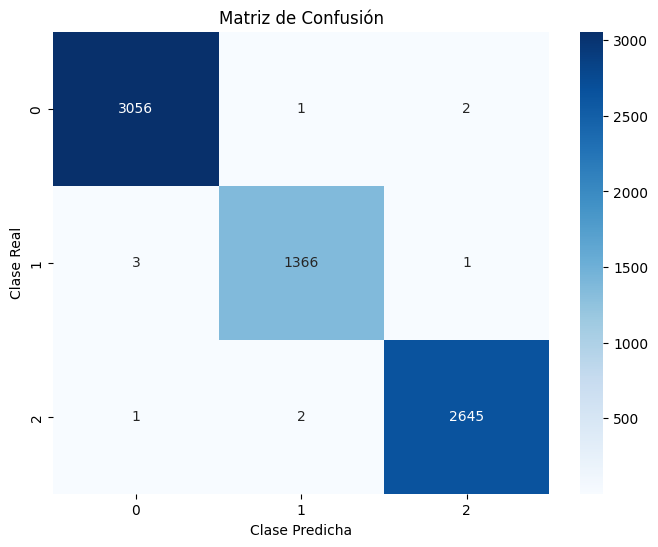

In [117]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [118]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9926553672316384
Precision:  0.9926837168625966
Precision per class: [0.99487836 0.99695122 0.98789713]
Recall:  0.9926553672316384
Recall per class: [0.99233716 0.98493976 0.99694656]
F1 Score:  0.9926543619618695
F1-score for the class 0: 0.9936061381074168
F1-score for the class 1: 0.990909090909091
F1-score for the class 2: 0.9924012158054711
jaccard: 0.997178356115556
Confusion Matrix: 
[[777   0   6]
 [  3 327   2]
 [  1   1 653]]


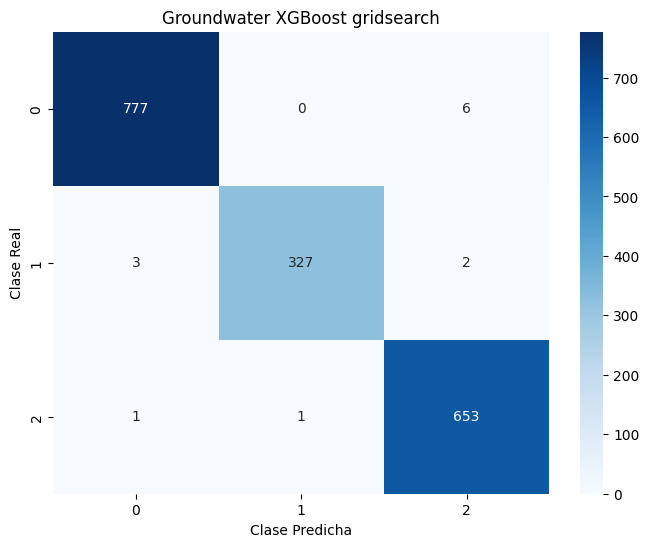

In [119]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater XGBoost gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [120]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9957627118644068
Precision:  0.9958042539049518
Precision per class: [1.         1.         0.99019608]
Recall:  0.9957627118644068
Recall per class: [0.98857143 1.         1.        ]
F1 Score:  0.9957609724193592
F1-score for the class 0: 0.9942528735632183
F1-score for the class 1: 1.0
F1-score for the class 2: 0.9950738916256158
jaccard: 0.9915669657693585
Confusion Matrix: 
[[173   0   2]
 [  0  95   0]
 [  0   0 202]]


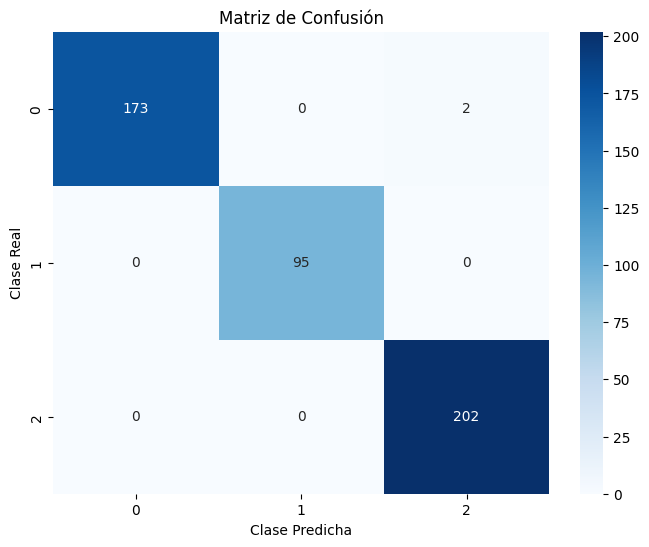

In [121]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####SVM

In [122]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_svm = SVC()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_svm, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_svm_bin.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, Accuracy: 0.9559322033898305, Best score (cv): 0.9477181529616099
Best model: SVC(C=10, gamma=1)
Best params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.9477181529616099


######Metrics

 Evaluate the model on the training set

In [123]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9913805284725166
Precision:  0.9914048920573746
Precision per class: [0.98669695 0.99116998 0.9969651 ]
Recall:  0.9913805284725166
Recall per class: [0.99411572 0.98321168 0.99244713]
F1 Score:  0.9913816806750254
F1-score for the class 0: 0.9903924442273245
F1-score for the class 1: 0.9871747893001099
F1-score for the class 2: 0.9947009841029523
jaccard: 0.982926178791953
Confusion Matrix: 
[[3041   10    8]
 [  23 1347    0]
 [  18    2 2628]]


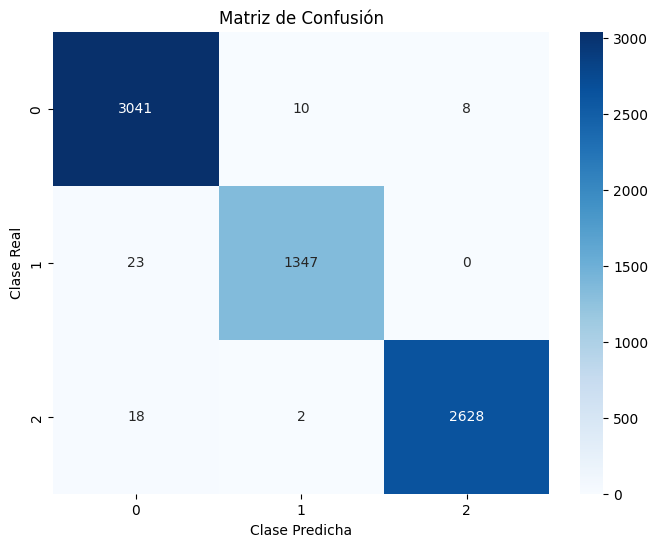

In [124]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [125]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9559322033898305
Precision:  0.955927950465039
Precision per class: [0.97099622 0.94966443 0.94108984]
Recall:  0.9559322033898305
Recall per class: [0.98339719 0.85240964 0.97557252]
F1 Score:  0.9553056368344195
F1-score for the class 0: 0.9771573604060914
F1-score for the class 1: 0.8984126984126984
F1-score for the class 2: 0.9580209895052474
jaccard: 0.982926178791953
Confusion Matrix: 
[[770   5   8]
 [ 17 283  32]
 [  6  10 639]]


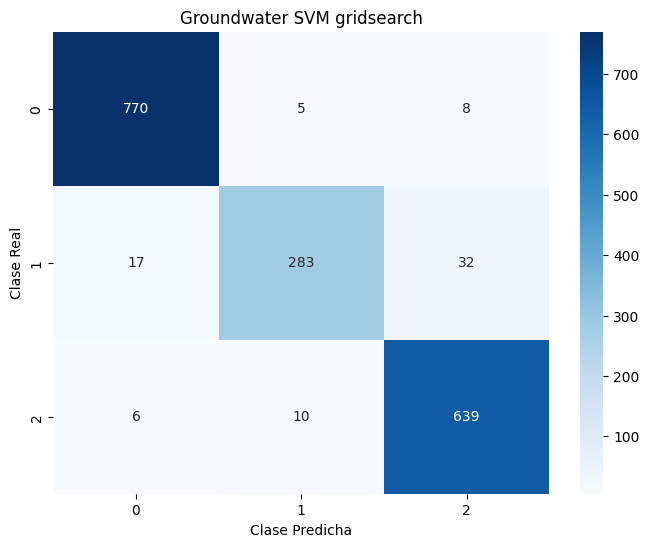

In [126]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater SVM gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [127]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9533898305084746
Precision:  0.9531355685944878
Precision per class: [0.95       0.93258427 0.96551724]
Recall:  0.9533898305084746
Recall per class: [0.97714286 0.87368421 0.97029703]
F1 Score:  0.952996017833943
F1-score for the class 0: 0.9633802816901409
F1-score for the class 1: 0.9021739130434783
F1-score for the class 2: 0.9679012345679012
jaccard: 0.9113147949035489
Confusion Matrix: 
[[171   3   1]
 [  6  83   6]
 [  3   3 196]]


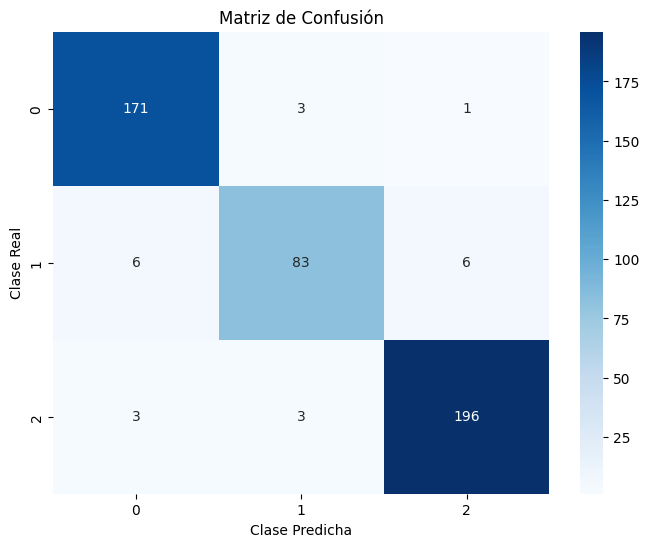

In [128]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####KNN

In [129]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_knn = KNeighborsClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_knn, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_knn_bin.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}, Accuracy: 0.9305084745762712, Best score (cv): 0.9162083008923758
Best model: KNeighborsClassifier(n_neighbors=3, weights='distance')
Best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
Best score: 0.9162083008923758


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


######Metrics

 Evaluate the model on the training set

In [130]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3059    0    0]
 [   0 1370    0]
 [   0    0 2648]]


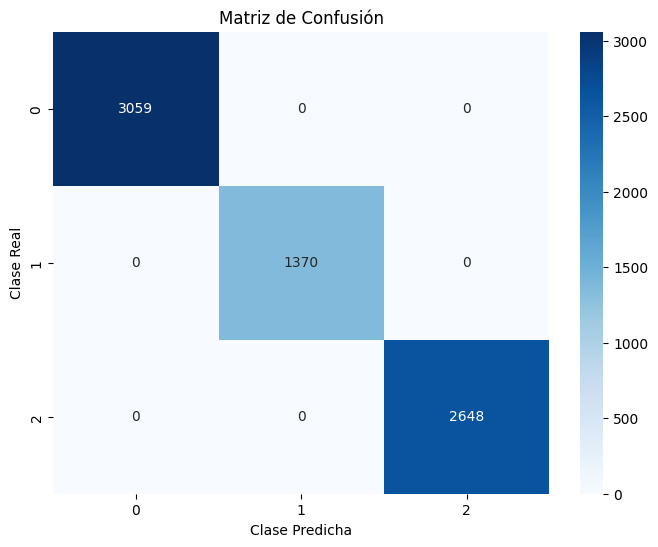

In [131]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [132]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9305084745762712
Precision:  0.9312101062801164
Precision per class: [0.91785714 0.89710611 0.9644588 ]
Recall:  0.9305084745762712
Recall per class: [0.98467433 0.84036145 0.91145038]
F1 Score:  0.9298892897358162
F1-score for the class 0: 0.9500924214417745
F1-score for the class 1: 0.8678071539657853
F1-score for the class 2: 0.9372056514913658
jaccard: 1.0
Confusion Matrix: 
[[771   5   7]
 [ 38 279  15]
 [ 31  27 597]]


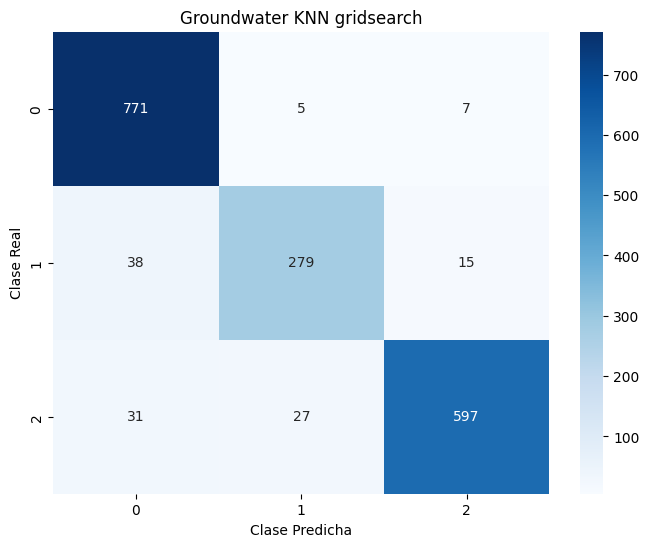

In [133]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater KNN gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [134]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.923728813559322
Precision:  0.9255414797655264
Precision per class: [0.88888889 0.89010989 0.97395833]
Recall:  0.923728813559322
Recall per class: [0.96       0.85263158 0.92574257]
F1 Score:  0.9237851481265541
F1-score for the class 0: 0.9230769230769231
F1-score for the class 1: 0.8709677419354839
F1-score for the class 2: 0.949238578680203
jaccard: 0.8596796738838006
Confusion Matrix: 
[[168   4   3]
 [ 12  81   2]
 [  9   6 187]]


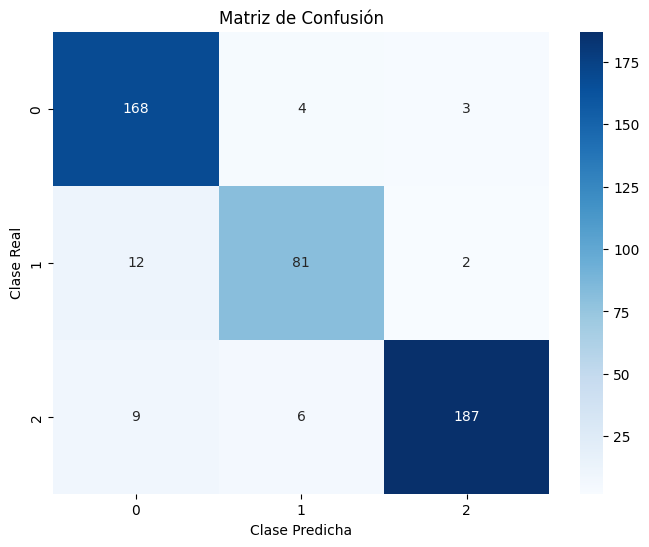

In [135]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

#####DT

In [136]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_dt = DecisionTreeClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_dt, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_dt.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}, Accuracy: 0.9977401129943503, Best score (cv): 0.9956198718332635
Best model: DecisionTreeClassifier(criterion='entropy', max_depth=20)
Best params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9956198718332635


######Metrics

 Evaluate the model on the training set

In [137]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[3059    0    0]
 [   0 1370    0]
 [   0    0 2648]]


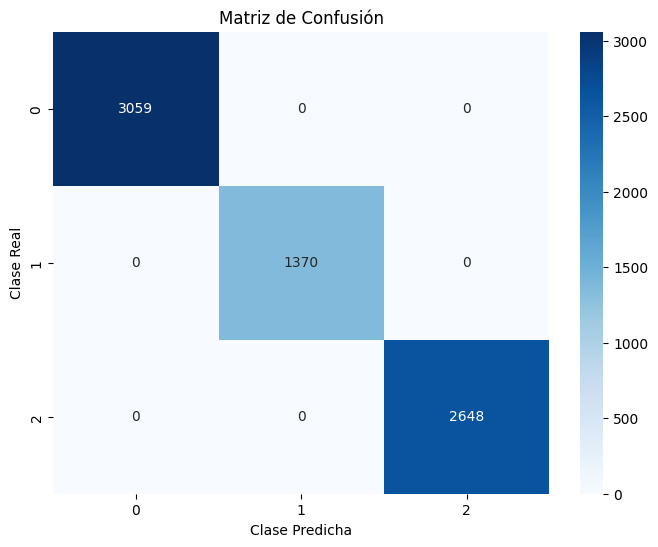

In [138]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [139]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9977401129943503
Precision:  0.9977538300626698
Precision per class: [1.        1.        0.9939302]
Recall:  0.9977401129943503
Recall per class: [0.99872286 0.99096386 1.        ]
F1 Score:  0.9977395259459743
F1-score for the class 0: 0.9993610223642172
F1-score for the class 1: 0.9954614220877458
F1-score for the class 2: 0.9969558599695586
jaccard: 1.0
Confusion Matrix: 
[[782   0   1]
 [  0 329   3]
 [  0   0 655]]


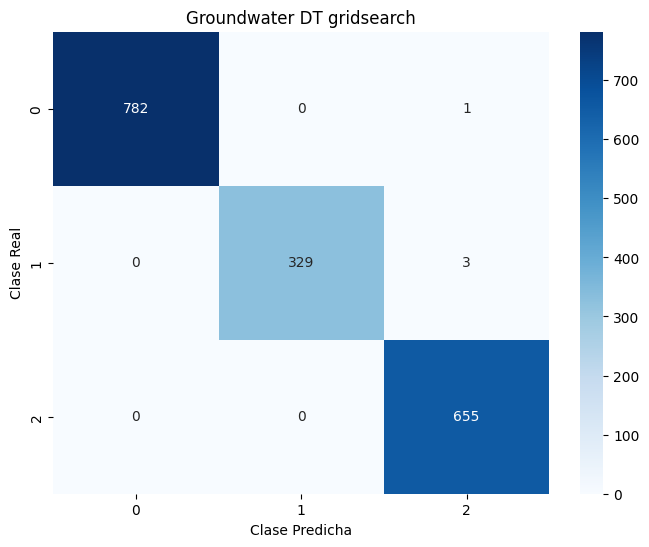

In [140]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater DT gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [141]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9978813559322034
Precision:  0.997903425141243
Precision per class: [1.         0.98958333 1.        ]
Recall:  0.9978813559322034
Recall per class: [0.99428571 1.         1.        ]
F1 Score:  0.9978838668141752
F1-score for the class 0: 0.997134670487106
F1-score for the class 1: 0.9947643979057592
F1-score for the class 2: 1.0
jaccard: 0.9957847810734464
Confusion Matrix: 
[[174   1   0]
 [  0  95   0]
 [  0   0 202]]


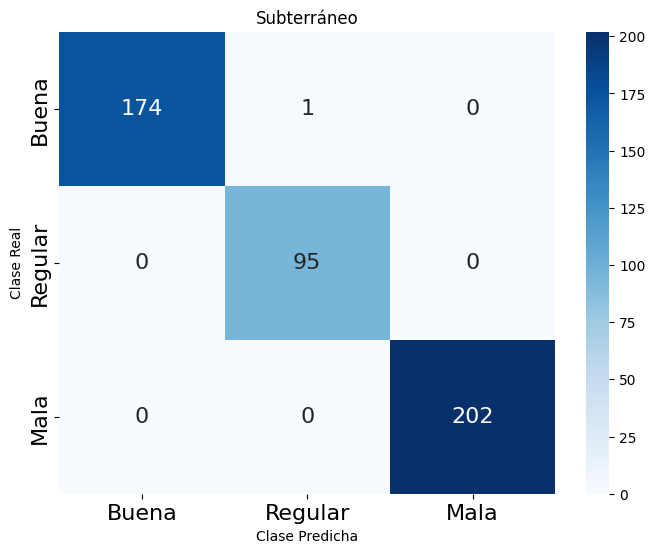

In [142]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Subterráneo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####MLR

In [143]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_mlr, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_mlr.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best params: {'C': 100, 'solver': 'sag'}, Accuracy: 0.8819209039548023, Best score (cv): 0.8882301211794534
Best model: LogisticRegression(C=100, max_iter=1000, solver='sag')
Best params: {'C': 100, 'solver': 'sag'}
Best score: 0.8882301211794534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


######Metrics

Evaluate the model on the training set

In [144]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8896425038858273
Precision:  0.8904057842549464
Precision per class: [0.87240537 0.8926507  0.91003861]
Recall:  0.8896425038858273
Recall per class: [0.93429225 0.78905109 0.89010574]
F1 Score:  0.8889069529457082
F1-score for the class 0: 0.9022888713496449
F1-score for the class 1: 0.837659821774506
F1-score for the class 2: 0.8999618174875906
jaccard: 0.8009194538269961
Confusion Matrix: 
[[2858   59  142]
 [ 198 1081   91]
 [ 220   71 2357]]


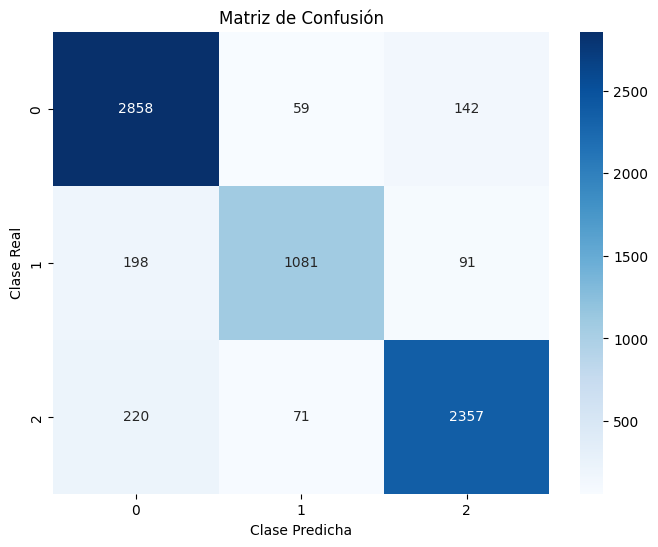

In [145]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [146]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8819209039548023
Precision:  0.881707592669147
Precision per class: [0.87560976 0.86       0.9       ]
Recall:  0.8819209039548023
Recall per class: [0.91698595 0.77710843 0.89312977]
F1 Score:  0.8812045165070737
F1-score for the class 0: 0.8958203368683718
F1-score for the class 1: 0.8164556962025317
F1-score for the class 2: 0.896551724137931
jaccard: 0.8009194538269961
Confusion Matrix: 
[[718  20  45]
 [ 54 258  20]
 [ 48  22 585]]


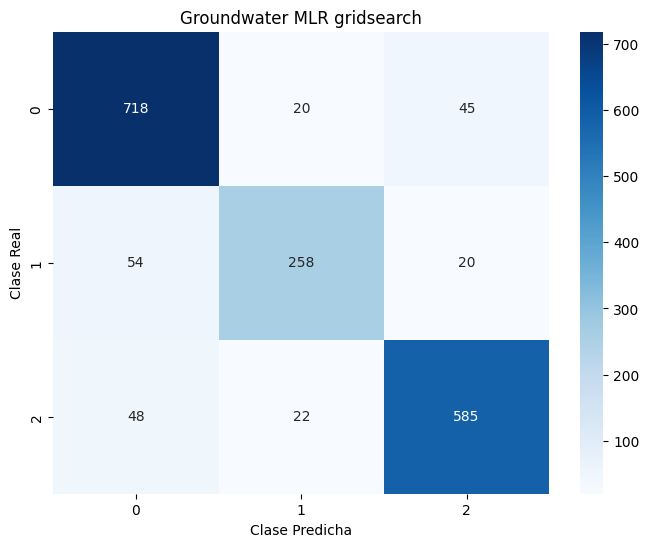

In [147]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater MLR gridsearch')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [148]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.913135593220339
Precision:  0.9171183264993605
Precision per class: [0.85641026 0.94936709 0.95454545]
Recall:  0.913135593220339
Recall per class: [0.95428571 0.78947368 0.93564356]
F1 Score:  0.9126261116464213
F1-score for the class 0: 0.9027027027027027
F1-score for the class 1: 0.8620689655172413
F1-score for the class 2: 0.945
jaccard: 0.8408339043149762
Confusion Matrix: 
[[167   4   4]
 [ 15  75   5]
 [ 13   0 189]]


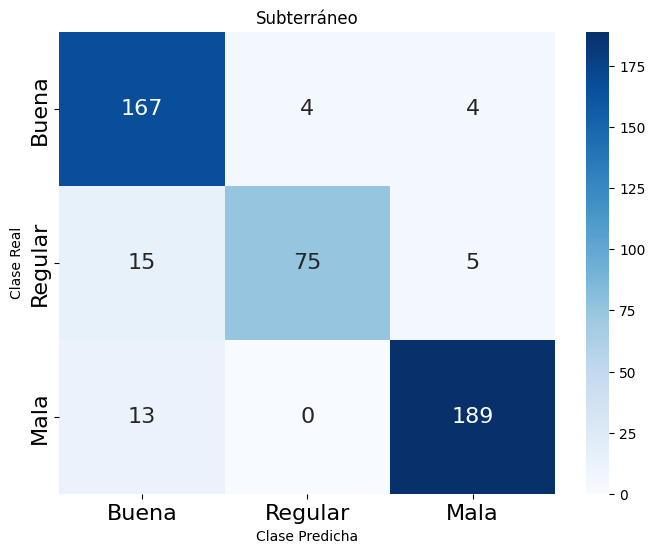

In [149]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Subterráneo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


####Balanced classes

In [150]:
X_train_subterraneo_num.shape, y_train_subterraneo_num.shape, X_val_subterraneo_num.shape, y_val_subterraneo_num.shape,

((8847, 14), (8847,), (472, 14), (472,))

#####Separation of data into training and test sets

Apply random subsampling

In [151]:
print('Before class balancing: ', Counter(y_train_subterraneo_num))
print("")
rus = RandomUnderSampler(random_state=42)
X_train_subterraneo_num, y_train_subterraneo_num = rus.fit_resample(X_train_subterraneo_num, y_train_subterraneo_num)
print('After the balancing y:', Counter(y_train_subterraneo_num))
print("")
print('After the balancing X:', Counter(X_train_subterraneo_num))

Before class balancing:  Counter({0: 3842, 2: 3303, 1: 1702})

After the balancing y: Counter({0: 1702, 1: 1702, 2: 1702})

After the balancing X: Counter({'Alc_Tot': 1, 'Cond_elec': 1, 'Dur_Tot': 1, 'SDT': 1, 'Fe_Tot': 1, 'Mn_Tot': 1, 'Fluo': 1, 'CF': 1, 'N_NO3': 1, 'As_Tot': 1, 'Cd_Tot': 1, 'Cr_Tot': 1, 'Hg_Tot': 1, 'Pb_Tot': 1})


In [152]:
# Guardar el conjunto de entrenamiento en un archivo Excel
#X_train_b_coa.to_excel("train_data_b_coa.xlsx", index=False)
#y_train_b_coa.to_excel("train_labels_data_b_coa.xlsx", index=False)

# Guardar el conjunto de prueba en un archivo Excel
#X_test_b_coa.to_excel("test_data_b_coa.xlsx", index=False)
#y_test_b_coa.to_excel("test_labels_data_b_coa.xlsx", index=False)

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X_train_subterraneo_num, y_train_subterraneo_num, test_size= 0.2, random_state=42)

In [154]:
# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [155]:
X_train.shape, X_test.shape

((4084, 14), (1022, 14))

#####XGBOOST

In [156]:
# Define a dictionary of hyperparameters for tuning a XGBoost model
parameters = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_xgb = XGBClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_xgb, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_xgb.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'learning_rate': 0.2, 'max_depth': 30, 'n_estimators': 200}, Accuracy: 0.9941291585127201, Best score (cv): 0.9924103607171142
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Best params: {'learning_rate': 0.2, 'max_depth': 30, 'n_estimators'

######Metrics

 Evaluate the model on the training set

In [157]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[1347    0    0]
 [   0 1372    0]
 [   0    0 1365]]


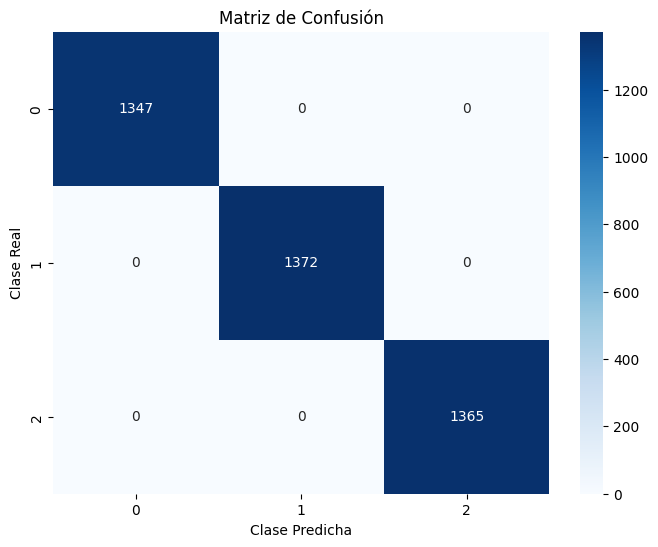

In [158]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [159]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9941291585127201
Precision:  0.9941941339831376
Precision per class: [0.98611111 0.99696049 1.        ]
Recall:  0.9941291585127201
Recall per class: [1.         0.99393939 0.98813056]
F1 Score:  0.9941323542494627
F1-score for the class 0: 0.993006993006993
F1-score for the class 1: 0.9954476479514416
F1-score for the class 2: 0.9940298507462687
jaccard: 1.0
Confusion Matrix: 
[[355   0   0]
 [  2 328   0]
 [  3   1 333]]


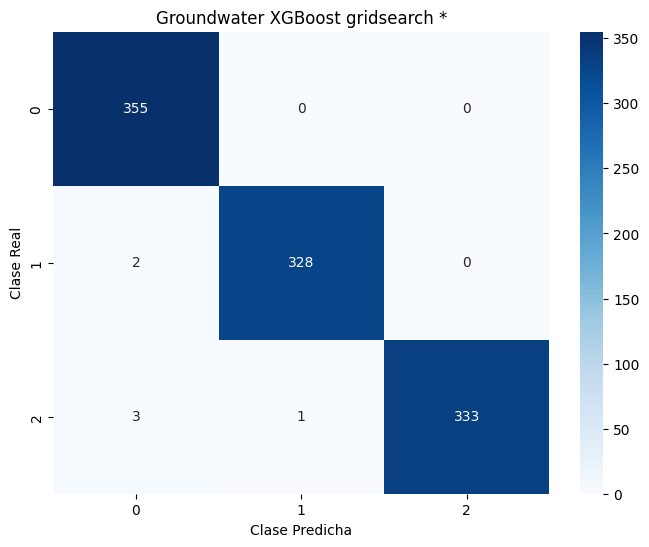

In [160]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater XGBoost gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [161]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9915254237288136
Precision:  0.9915322508873478
Precision per class: [0.99425287 0.9893617  0.99019608]
Recall:  0.9915254237288136
Recall per class: [0.98857143 0.97894737 1.        ]
F1 Score:  0.9915099398435774
F1-score for the class 0: 0.9914040114613181
F1-score for the class 1: 0.9841269841269841
F1-score for the class 2: 0.9950738916256158
jaccard: 0.9831947103764465
Confusion Matrix: 
[[173   1   1]
 [  1  93   1]
 [  0   0 202]]


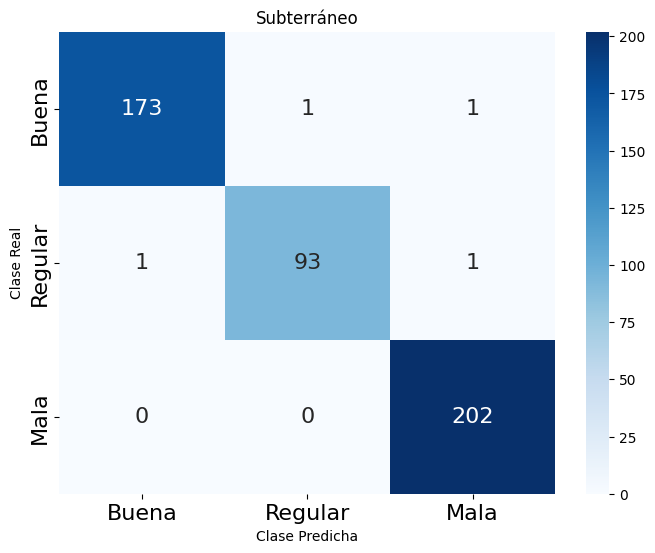

In [162]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Subterráneo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####SVM

In [163]:
# Define a dictionary of hyperparameters for tuning a SVM model
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_svm = SVC()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_svm, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_svm.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, Accuracy: 0.9393346379647749, Best score (cv): 0.9348702210382317
Best model: SVC(C=10, gamma=1)
Best params: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.9348702210382317


######Metrics

 Evaluate the model on the training set

In [164]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9951028403525954
Precision:  0.9951135478007469
Precision per class: [0.9925816  0.99273784 1.        ]
Recall:  0.9951028403525954
Recall per class: [0.99331849 0.99635569 0.9956044 ]
F1 Score:  0.995105425671152
F1-score for the class 0: 0.9929499072356215
F1-score for the class 1: 0.9945434703528556
F1-score for the class 2: 0.9977973568281938
jaccard: 0.99026654091298
Confusion Matrix: 
[[1338    9    0]
 [   5 1367    0]
 [   5    1 1359]]


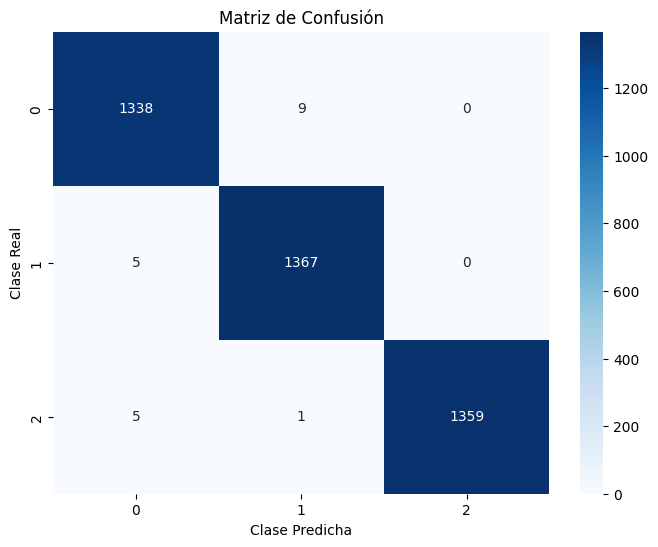

In [165]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [166]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9393346379647749
Precision:  0.9393589758926334
Precision per class: [0.94277929 0.94303797 0.93215339]
Recall:  0.9393346379647749
Recall per class: [0.97464789 0.9030303  0.93768546]
F1 Score:  0.9391121336311019
F1-score for the class 0: 0.9584487534626038
F1-score for the class 1: 0.9226006191950464
F1-score for the class 2: 0.9349112426035503
jaccard: 0.99026654091298
Confusion Matrix: 
[[346   7   2]
 [ 11 298  21]
 [ 10  11 316]]


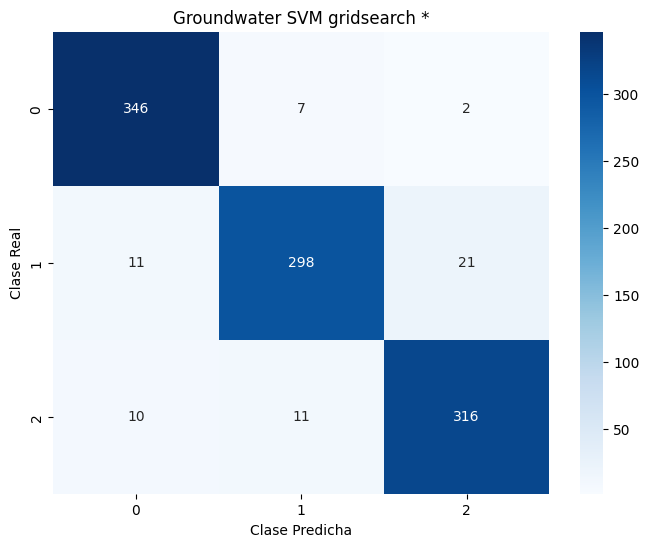

In [167]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater SVM gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [168]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9555084745762712
Precision:  0.955985283482556
Precision per class: [0.97687861 0.89795918 0.96517413]
Recall:  0.9555084745762712
Recall per class: [0.96571429 0.92631579 0.96039604]
F1 Score:  0.9556880896150667
F1-score for the class 0: 0.9712643678160919
F1-score for the class 1: 0.9119170984455959
F1-score for the class 2: 0.9627791563275434
jaccard: 0.9159849653616442
Confusion Matrix: 
[[169   5   1]
 [  1  88   6]
 [  3   5 194]]


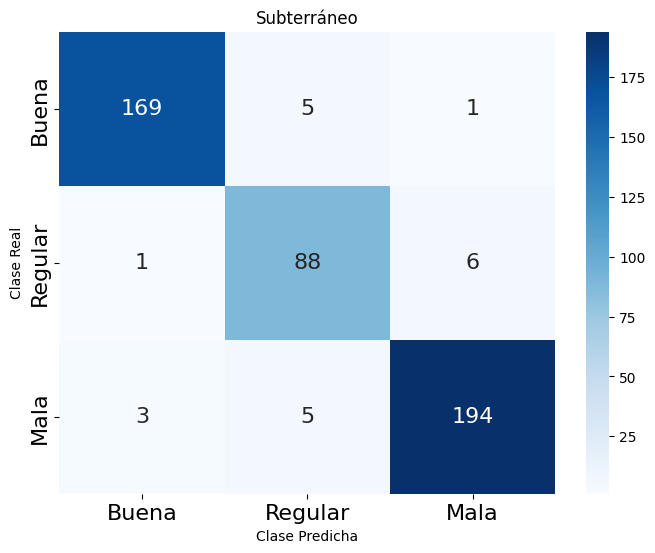

In [169]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Subterráneo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####KNN

In [170]:
# Define a dictionary of hyperparameters for tuning a KNN model
parameters = {
    'n_neighbors': [3, 5, 7, 9],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de ponderación
    'p': [1, 2]  # Parámetro para la distancia (1 para la distancia de Manhattan, 2 para la Euclidiana)
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_knn = KNeighborsClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_knn, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_knn.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}, Accuracy: 0.9168297455968689, Best score (cv): 0.9187105503155975
Best model: KNeighborsClassifier(weights='distance')
Best params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Best score: 0.9187105503155975


######Metrics

 Evaluate the model on the training set

In [171]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  1.0
Precision:  1.0
Precision per class: [1. 1. 1.]
Recall:  1.0
Recall per class: [1. 1. 1.]
F1 Score:  1.0
F1-score for the class 0: 1.0
F1-score for the class 1: 1.0
F1-score for the class 2: 1.0
jaccard: 1.0
Confusion Matrix: 
[[1347    0    0]
 [   0 1372    0]
 [   0    0 1365]]


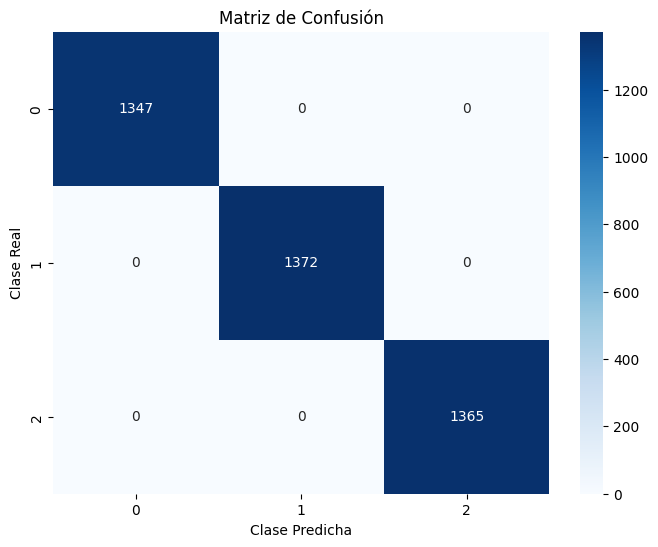

In [172]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [173]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9168297455968689
Precision:  0.921083125600347
Precision per class: [0.8984375  0.88252149 0.98269896]
Recall:  0.9168297455968689
Recall per class: [0.97183099 0.93333333 0.84272997]
F1 Score:  0.9164571775902313
F1-score for the class 0: 0.9336941813261164
F1-score for the class 1: 0.9072164948453608
F1-score for the class 2: 0.9073482428115016
jaccard: 1.0
Confusion Matrix: 
[[345   9   1]
 [ 18 308   4]
 [ 21  32 284]]


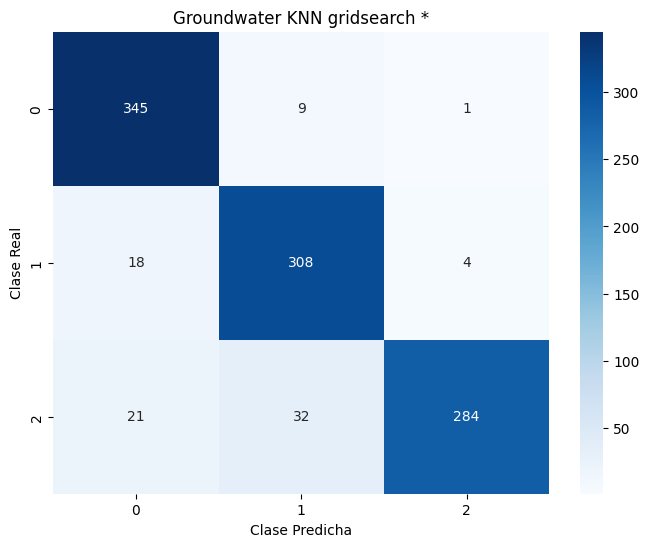

In [174]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater KNN gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [175]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9173728813559322
Precision:  0.9231199722188252
Precision per class: [0.9027027  0.82075472 0.98895028]
Recall:  0.9173728813559322
Recall per class: [0.95428571 0.91578947 0.88613861]
F1 Score:  0.9182511408711483
F1-score for the class 0: 0.9277777777777778
F1-score for the class 1: 0.8656716417910447
F1-score for the class 2: 0.9347258485639687
jaccard: 0.8499363739524087
Confusion Matrix: 
[[167   7   1]
 [  7  87   1]
 [ 11  12 179]]


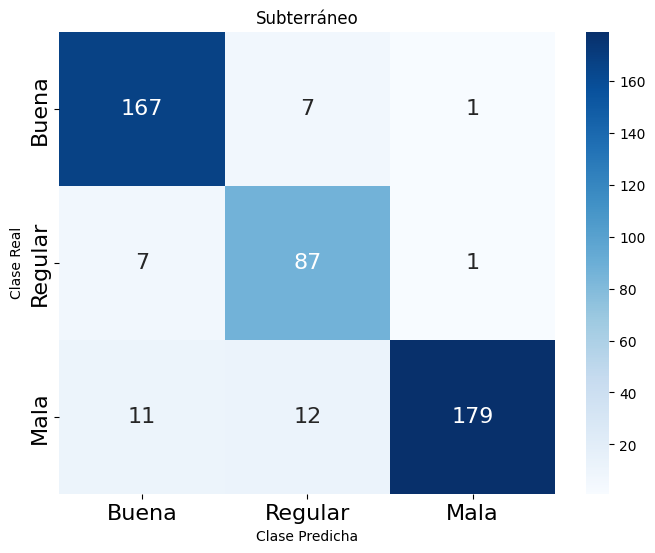

In [176]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Subterráneo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####DT

In [177]:
# Define a dictionary of hyperparameters for tuning a DT model
parameters = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división de nodos
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en una hoja
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_dt = DecisionTreeClassifier()

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_dt, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_dt.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...
Best params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}, Accuracy: 0.9951076320939335, Best score (cv): 0.9904504763961889
Best model: DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=10)
Best params: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 0.9904504763961889


######Metrics

 Evaluate the model on the training set

In [178]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9992654260528894
Precision:  0.9992670584394384
Precision per class: [0.99777778 1.         1.        ]
Recall:  0.9992654260528894
Recall per class: [1.         0.99854227 0.9992674 ]
F1 Score:  0.9992656111431636
F1-score for the class 0: 0.9988876529477196
F1-score for the class 1: 0.9992706053975201
F1-score for the class 2: 0.9996335654085746
jaccard: 0.9985324844923278
Confusion Matrix: 
[[1347    0    0]
 [   2 1370    0]
 [   1    0 1364]]


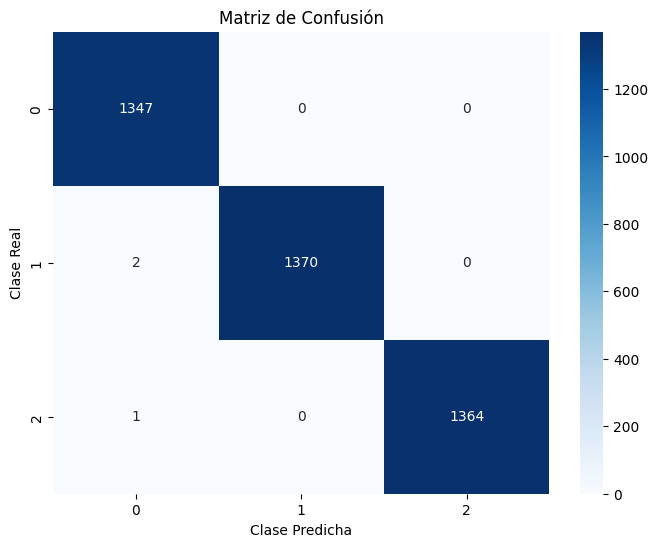

In [179]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [180]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9951076320939335
Precision:  0.9951322305917852
Precision per class: [0.99162011 0.99393939 1.        ]
Recall:  0.9951076320939335
Recall per class: [1.         0.99393939 0.99109792]
F1 Score:  0.995107245550003
F1-score for the class 0: 0.9957924263674615
F1-score for the class 1: 0.9939393939393939
F1-score for the class 2: 0.9955290611028316
jaccard: 0.9985324844923278
Confusion Matrix: 
[[355   0   0]
 [  2 328   0]
 [  1   2 334]]


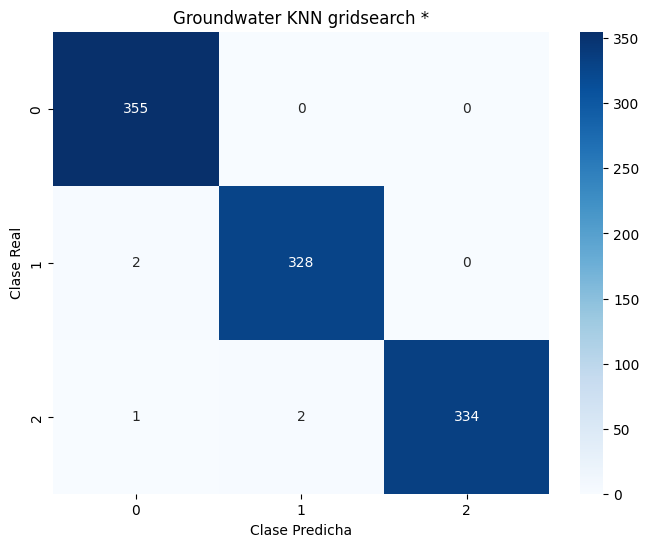

In [181]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater KNN gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [182]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9978813559322034
Precision:  0.997903425141243
Precision per class: [1.         0.98958333 1.        ]
Recall:  0.9978813559322034
Recall per class: [1.        1.        0.9950495]
F1 Score:  0.9978842735302077
F1-score for the class 0: 1.0
F1-score for the class 1: 0.9947643979057592
F1-score for the class 2: 0.9975186104218362
jaccard: 0.9957847810734464
Confusion Matrix: 
[[175   0   0]
 [  0  95   0]
 [  0   1 201]]


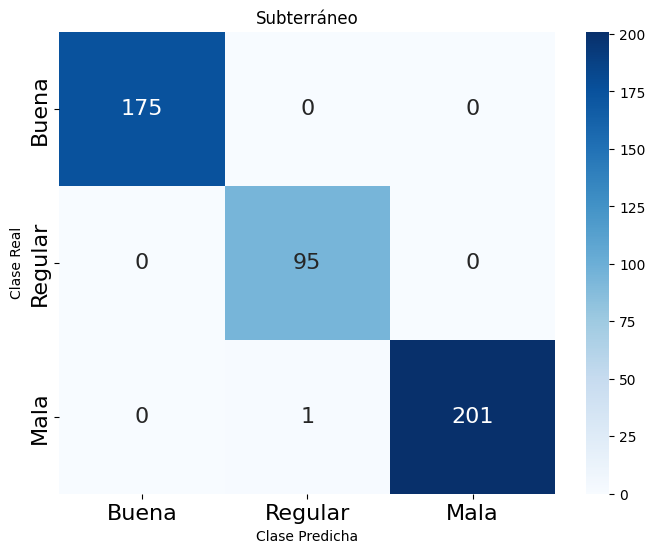

In [183]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Subterráneo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####MLR

In [184]:
# Define a dictionary of hyperparameters for tuning a MLR model
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parámetro de regularización
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Método de optimización
}

# Inform the user to wait during the hyperparameter search
print("Wait a moment...")

# Inicializar el estimador (modelo)
model_subterraneo_mlr = LogisticRegression(max_iter=1000)  # Usamos max_iter para evitar advertencias

# Inicializar el GridSearchCV
grid_search = GridSearchCV(model_subterraneo_mlr, parameters, cv=5, scoring='accuracy')

# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtener la mejor combinación de hiperparámetros
best_params = grid_search.best_params_

# Obtener el mejor modelo entrenado
best_model = grid_search.best_estimator_

# Obtener el mejor score
best_score = grid_search.best_score_

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test_scaled)

# Calcular la métrica de evaluación (por ejemplo, precisión)
accuracy = accuracy_score(y_test, y_pred)

# Imprimir los resultados
print("Best params: {}, Accuracy: {}, Best score (cv): {}".format(best_params, accuracy, best_score))

# Guardar el mejor modelo en un archivo
#with open('best_model_subterraneo_mlr.pkl', 'wb') as model_file:
#    pickle.dump(best_model, model_file)

# Imprimir el mejor modelo, los mejores parámetros y el mejor score
print("Best model:", best_model)
print("Best params:", best_params)
print("Best score:", best_score)


Wait a moment...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best params: {'C': 10, 'solver': 'newton-cg'}, Accuracy: 0.8816046966731899, Best score (cv): 0.8883417932656539
Best model: LogisticRegression(C=10, max_iter=1000, solver='newton-cg')
Best params: {'C': 10, 'solver': 'newton-cg'}
Best score: 0.8883417932656539


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


######Metrics

 Evaluate the model on the training set

In [185]:
# Make predictions on the training set
y_pred = best_model.predict(X_train_scaled)

# Evaluation metrics on the training set
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_train, y_pred, average=None)
recall = recall_score(y_train, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_train, y_pred, average=None)
f1 = f1_score(y_train, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_train, y_pred, average=None)
jaccard = jaccard_score(y_train, y_pred, average='weighted')
confusion = confusion_matrix(y_train, y_pred)

# Print evaluation metrics for the training set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8910381978452497
Precision:  0.8916012497828462
Precision per class: [0.86194564 0.90236686 0.91004498]
Recall:  0.8910381978452497
Recall per class: [0.89458055 0.88921283 0.88937729]
F1 Score:  0.8911638394389733
F1-score for the class 0: 0.8779599271402551
F1-score for the class 1: 0.895741556534508
F1-score for the class 2: 0.8995924416450537
jaccard: 0.8038218139196007
Confusion Matrix: 
[[1205   80   62]
 [  94 1220   58]
 [  99   52 1214]]


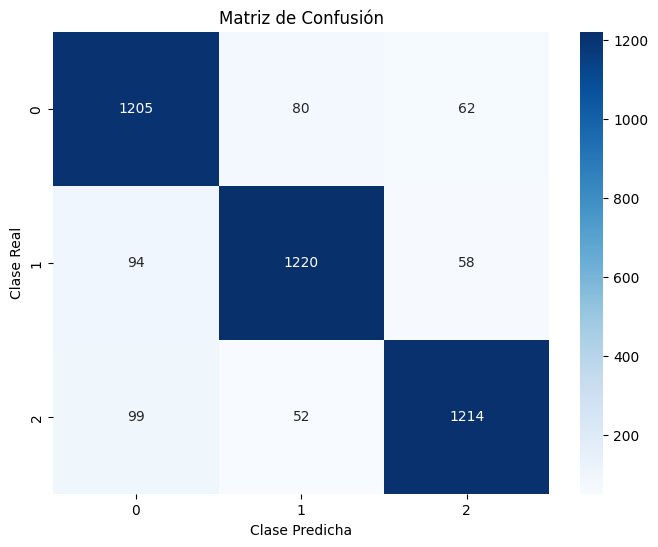

In [186]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_train, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the test set

In [187]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics on the testing set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_test, y_pred, average=None)
jaccard_t = jaccard_score(y_test, y_pred, average='weighted')
confusion = confusion_matrix(y_test, y_pred)

# Print evaluation metrics for the testing set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.8816046966731899
Precision:  0.8833741168609199
Precision per class: [0.84514436 0.88271605 0.92429022]
Recall:  0.8816046966731899
Recall per class: [0.90704225 0.86666667 0.8694362 ]
F1 Score:  0.8818092934044298
F1-score for the class 0: 0.875
F1-score for the class 1: 0.8746177370030581
F1-score for the class 2: 0.8960244648318043
jaccard: 0.8038218139196007
Confusion Matrix: 
[[322  24   9]
 [ 29 286  15]
 [ 30  14 293]]


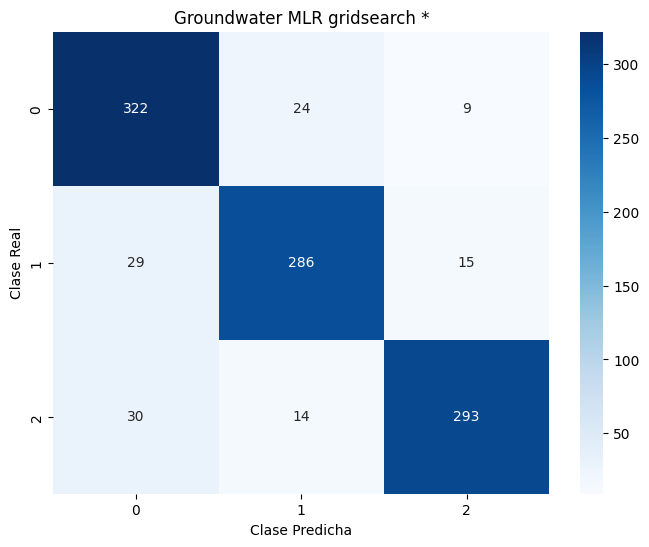

In [188]:
classes = [0, 1, 2]  # Por ejemplo, si tus clases son 0, 1 y 2

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Groundwater MLR gridsearch *')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()

 Evaluate the model on the validation set

In [189]:
# Transform the validation data using the scaler trained on the validation data
X_val = scaler.transform(X_val_subterraneo_num)

# Make predictions on the validation set using the trained xgboost model
y_pred = best_model.predict(X_val)

# Evaluation metrics on the validation set
accuracy = accuracy_score(y_val_subterraneo_num, y_pred)
precision = precision_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate precision for each class
precision_x_class = precision_score(y_val_subterraneo_num, y_pred, average=None)
recall = recall_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate recall for each class
recall_x_class = recall_score(y_val_subterraneo_num, y_pred, average=None)
f1 = f1_score(y_val_subterraneo_num, y_pred, average='weighted')
# Calculate f1 score for each class
f1_score_x_class = f1_score(y_val_subterraneo_num, y_pred, average=None)
jaccard = jaccard_score(y_val_subterraneo_num, y_pred, average='weighted')
confusion = confusion_matrix(y_val_subterraneo_num, y_pred)

# Print evaluation metrics for the validation set
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Precision per class:" , precision_x_class)
print("Recall: ", recall)
print("Recall per class:" , recall_x_class)
print("F1 Score: ", f1)
# Print F1-score for each class
for clase, f1 in enumerate(f1_score_x_class):
    print(f"F1-score for the class {clase}: {f1}")
print("jaccard:" , jaccard)
print("Confusion Matrix: ")
print(confusion)

Accuracy:  0.9173728813559322
Precision:  0.9190599453610333
Precision per class: [0.88043478 0.88421053 0.96891192]
Recall:  0.9173728813559322
Recall per class: [0.92571429 0.88421053 0.92574257]
F1 Score:  0.9177955045691176
F1-score for the class 0: 0.9025069637883009
F1-score for the class 1: 0.8842105263157894
F1-score for the class 2: 0.9468354430379747
jaccard: 0.849147071059996
Confusion Matrix: 
[[162  10   3]
 [  8  84   3]
 [ 14   1 187]]


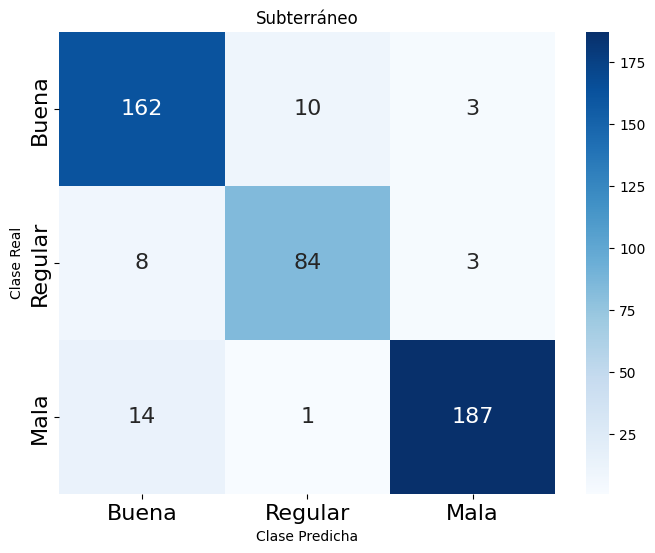

In [190]:
# Definir las etiquetas de las clases
classes = ['Buena', 'Regular', 'Mala']

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_val_subterraneo_num, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})

# Ajustar el tamaño de los valores de la matriz de confusión
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title('Subterráneo')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Real')
plt.show()


#####Empaquetado del escalador

In [191]:
# Save the scaler used for preprocessing to a file
#with open('scaler_coa.pkl', 'wb') as scaler_file:
#    pickle.dump(scaler_coa, scaler_file)